# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from

**Sea level and global ice volumes from the Last Glacial Maximum to the Holocene**, K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#
# load x,y data
def load_data_xy(filename):
    x, y, sx, sy = np.loadtxt(filename, skiprows=1).T
    sy /= 2  # input data are 2 sigma and we require sigma
    return x, y, sy

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [4]:
data_x,data_y,sy = load_data_xy("../../data/eustatic_sea_level/ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [5]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [6]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

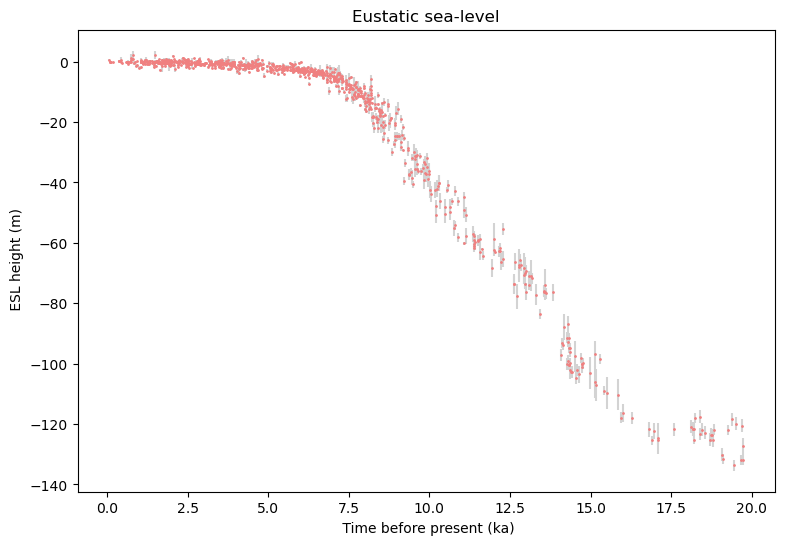

In [7]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [8]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [9]:
# Reference model for plotting
ESLref = load_data_ref("../../data/eustatic_sea_level/ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [10]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

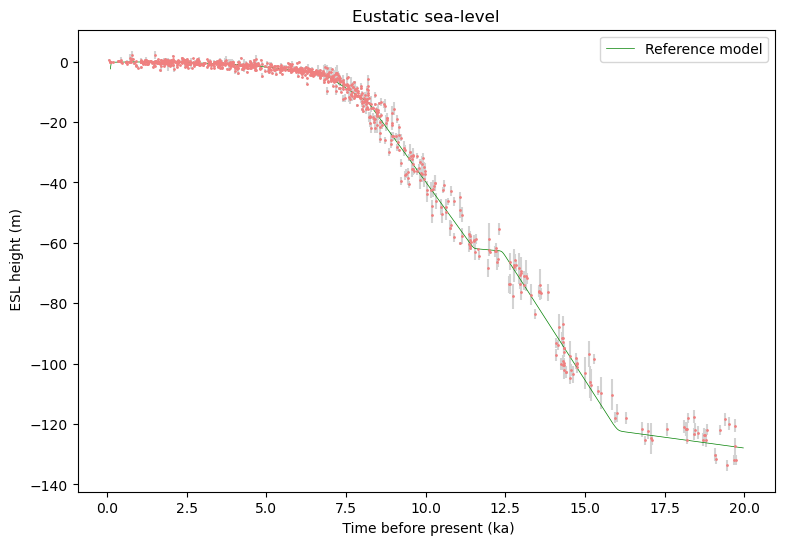

In [11]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [12]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [13]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [14]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [15]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'matrix solvers', 'optimization', 'sampling'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [16]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim",
        "cofi.border_collie_optimization"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee",
        "bayesbay",
        "neighpy"
    ]
}


In [17]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [18]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [19]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [20]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

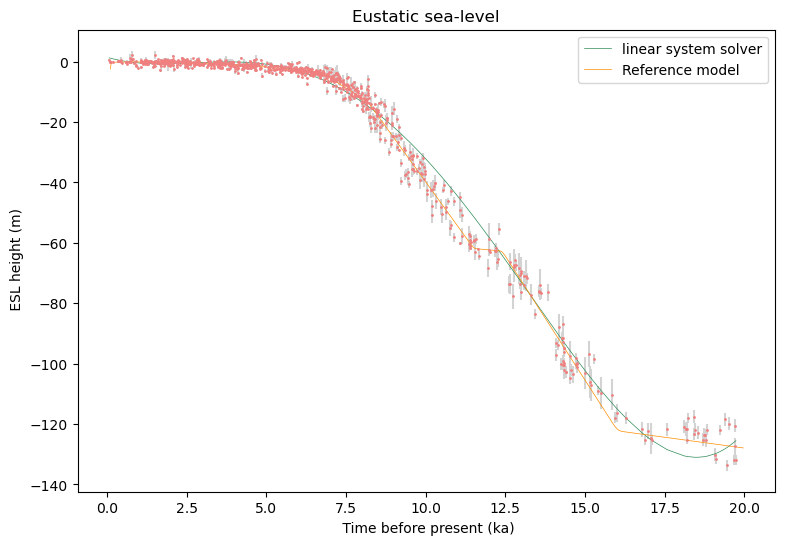

In [21]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [22]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]

Summary for inversion result
SUCCESS
----------------------------
fun: 310.0689929995379
nit: 560
nfev: 916
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[-0.81319113, -0.46081553,  0.61740809, -0.12663625,  0.00398136],
       [-0.81328903, -0.46081801,  0.61741429, -0.1266371 ,  0.0039814 ],
       [-0.81317886, -0.46081571,  0.61738786, -0.12663294,  0.00398125],
       [-0.81315239, -0.46081502,  0.61739705, -0.12663469,  0.0039813 ],
       [-0.81320724, -0.46081746,  0.61741117, -0.12663795,  0.00398147],
       [-0.81318091, -0.4608153 ,  0.61740441, -0.12663565,  0.00398136]]), array([310.068993  , 310.06899312, 310.0689937 , 310.06899379,
       310.06899388, 310.06899454]))
model: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]


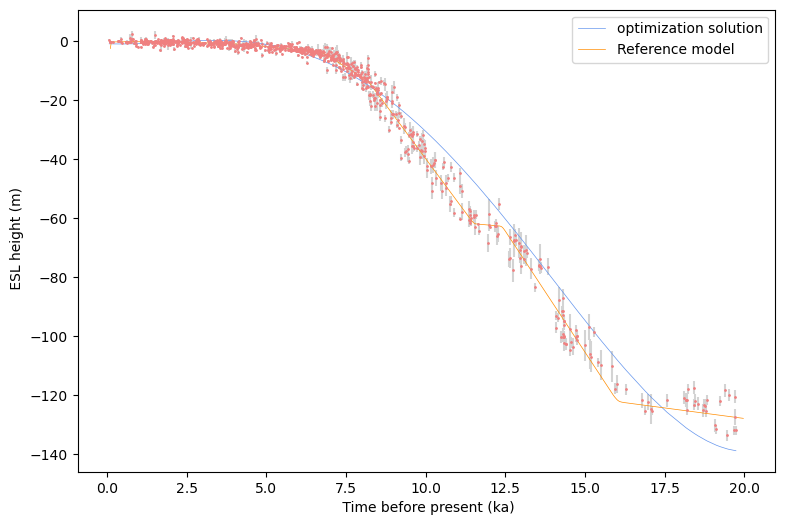

In [23]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [24]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


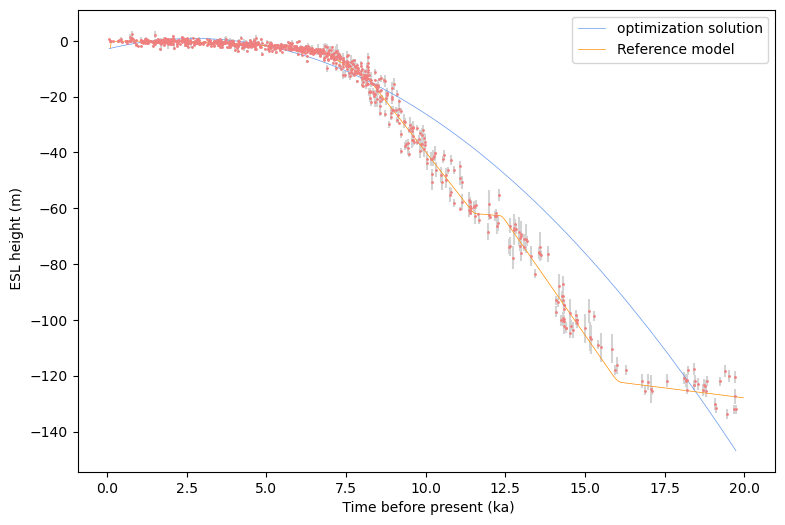

In [25]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [26]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [27]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [28]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [29]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                                                                                         | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                              | 14/10000 [00:00<01:12, 137.90it/s]

  0%|▌                                                                                                                                                                                                              | 28/10000 [00:00<01:11, 138.52it/s]

  0%|▊                                                                                                                                                                                                              | 42/10000 [00:00<01:11, 138.76it/s]

  1%|█▏                                                                                                                                                                                                             | 56/10000 [00:00<01:11, 139.08it/s]

  1%|█▍                                                                                                                                                                                                             | 71/10000 [00:00<01:11, 139.51it/s]

  1%|█▊                                                                                                                                                                                                             | 85/10000 [00:00<01:12, 136.98it/s]

  1%|██                                                                                                                                                                                                             | 99/10000 [00:00<01:11, 137.93it/s]

  1%|██▎                                                                                                                                                                                                           | 113/10000 [00:00<01:11, 138.41it/s]

  1%|██▌                                                                                                                                                                                                           | 127/10000 [00:00<01:11, 138.40it/s]

  1%|██▉                                                                                                                                                                                                           | 141/10000 [00:01<01:11, 138.67it/s]

  2%|███▏                                                                                                                                                                                                          | 155/10000 [00:01<01:11, 138.40it/s]

  2%|███▍                                                                                                                                                                                                          | 169/10000 [00:01<01:11, 138.38it/s]

  2%|███▊                                                                                                                                                                                                          | 183/10000 [00:01<01:10, 138.75it/s]

  2%|████                                                                                                                                                                                                          | 197/10000 [00:01<01:10, 138.97it/s]

  2%|████▎                                                                                                                                                                                                         | 211/10000 [00:01<01:10, 139.19it/s]

  2%|████▋                                                                                                                                                                                                         | 225/10000 [00:01<01:10, 139.40it/s]

  2%|████▉                                                                                                                                                                                                         | 239/10000 [00:01<01:09, 139.54it/s]

  3%|█████▏                                                                                                                                                                                                        | 253/10000 [00:01<01:09, 139.55it/s]

  3%|█████▌                                                                                                                                                                                                        | 267/10000 [00:01<01:09, 139.20it/s]

  3%|█████▊                                                                                                                                                                                                        | 281/10000 [00:02<01:32, 104.72it/s]

  3%|██████                                                                                                                                                                                                        | 295/10000 [00:02<01:26, 112.28it/s]

  3%|██████▎                                                                                                                                                                                                       | 309/10000 [00:02<01:21, 119.16it/s]

  3%|██████▋                                                                                                                                                                                                       | 323/10000 [00:02<01:17, 124.53it/s]

  3%|██████▉                                                                                                                                                                                                       | 338/10000 [00:02<01:14, 129.09it/s]

  4%|███████▎                                                                                                                                                                                                      | 353/10000 [00:02<01:12, 132.43it/s]

  4%|███████▌                                                                                                                                                                                                      | 368/10000 [00:02<01:11, 134.82it/s]

  4%|███████▉                                                                                                                                                                                                      | 383/10000 [00:02<01:10, 136.44it/s]

  4%|████████▏                                                                                                                                                                                                     | 397/10000 [00:02<01:09, 137.42it/s]

  4%|████████▍                                                                                                                                                                                                     | 412/10000 [00:03<01:09, 138.40it/s]

  4%|████████▊                                                                                                                                                                                                     | 426/10000 [00:03<01:09, 138.36it/s]

  4%|█████████                                                                                                                                                                                                     | 440/10000 [00:03<01:09, 137.13it/s]

  5%|█████████▎                                                                                                                                                                                                    | 454/10000 [00:03<01:09, 137.64it/s]

  5%|█████████▋                                                                                                                                                                                                    | 468/10000 [00:03<01:09, 138.10it/s]

  5%|█████████▉                                                                                                                                                                                                    | 482/10000 [00:03<01:08, 138.57it/s]

  5%|██████████▏                                                                                                                                                                                                   | 496/10000 [00:03<01:08, 138.85it/s]

  5%|██████████▌                                                                                                                                                                                                   | 510/10000 [00:03<01:08, 139.08it/s]

  5%|██████████▊                                                                                                                                                                                                   | 524/10000 [00:03<01:08, 139.19it/s]

  5%|███████████                                                                                                                                                                                                   | 538/10000 [00:03<01:07, 139.30it/s]

  6%|███████████▎                                                                                                                                                                                                  | 552/10000 [00:04<01:07, 139.50it/s]

  6%|███████████▋                                                                                                                                                                                                  | 566/10000 [00:04<01:09, 136.55it/s]

  6%|███████████▉                                                                                                                                                                                                  | 580/10000 [00:04<01:08, 137.49it/s]

  6%|████████████▏                                                                                                                                                                                                 | 594/10000 [00:04<01:08, 138.14it/s]

  6%|████████████▌                                                                                                                                                                                                 | 608/10000 [00:04<01:07, 138.65it/s]

  6%|████████████▊                                                                                                                                                                                                 | 622/10000 [00:04<01:17, 120.88it/s]

  6%|█████████████                                                                                                                                                                                                 | 636/10000 [00:04<01:14, 125.95it/s]

  6%|█████████████▍                                                                                                                                                                                                | 650/10000 [00:04<01:12, 129.76it/s]

  7%|█████████████▋                                                                                                                                                                                                | 664/10000 [00:04<01:10, 132.40it/s]

  7%|█████████████▉                                                                                                                                                                                                | 678/10000 [00:05<01:09, 134.54it/s]

  7%|██████████████▎                                                                                                                                                                                               | 692/10000 [00:05<01:08, 136.09it/s]

  7%|██████████████▌                                                                                                                                                                                               | 706/10000 [00:05<01:07, 137.18it/s]

  7%|██████████████▊                                                                                                                                                                                               | 720/10000 [00:05<01:07, 137.95it/s]

  7%|███████████████                                                                                                                                                                                               | 734/10000 [00:05<01:06, 138.49it/s]

  7%|███████████████▍                                                                                                                                                                                              | 749/10000 [00:05<01:06, 139.20it/s]

  8%|███████████████▋                                                                                                                                                                                              | 763/10000 [00:05<01:07, 137.60it/s]

  8%|████████████████                                                                                                                                                                                              | 777/10000 [00:05<01:06, 138.12it/s]

  8%|████████████████▎                                                                                                                                                                                             | 791/10000 [00:05<01:06, 138.65it/s]

  8%|████████████████▌                                                                                                                                                                                             | 805/10000 [00:05<01:06, 138.85it/s]

  8%|████████████████▉                                                                                                                                                                                             | 820/10000 [00:06<01:05, 139.25it/s]

  8%|█████████████████▏                                                                                                                                                                                            | 834/10000 [00:06<01:05, 139.14it/s]

  8%|█████████████████▍                                                                                                                                                                                            | 848/10000 [00:06<01:05, 139.12it/s]

  9%|█████████████████▊                                                                                                                                                                                            | 863/10000 [00:06<01:05, 139.36it/s]

  9%|██████████████████                                                                                                                                                                                            | 877/10000 [00:06<01:05, 139.46it/s]

  9%|██████████████████▎                                                                                                                                                                                           | 891/10000 [00:06<01:05, 139.57it/s]

  9%|██████████████████▋                                                                                                                                                                                           | 906/10000 [00:06<01:05, 139.77it/s]

  9%|██████████████████▉                                                                                                                                                                                           | 920/10000 [00:06<01:04, 139.83it/s]

  9%|███████████████████▏                                                                                                                                                                                          | 934/10000 [00:06<01:04, 139.75it/s]

  9%|███████████████████▌                                                                                                                                                                                          | 948/10000 [00:06<01:04, 139.80it/s]

 10%|███████████████████▊                                                                                                                                                                                          | 962/10000 [00:07<01:05, 138.92it/s]

 10%|████████████████████                                                                                                                                                                                          | 976/10000 [00:07<01:06, 136.54it/s]

 10%|████████████████████▍                                                                                                                                                                                         | 990/10000 [00:07<01:05, 137.46it/s]

 10%|████████████████████▌                                                                                                                                                                                        | 1004/10000 [00:07<01:05, 138.08it/s]

 10%|████████████████████▊                                                                                                                                                                                        | 1018/10000 [00:07<01:05, 138.02it/s]

 10%|█████████████████████▏                                                                                                                                                                                       | 1032/10000 [00:07<01:04, 138.50it/s]

 10%|█████████████████████▍                                                                                                                                                                                       | 1047/10000 [00:07<01:04, 139.07it/s]

 11%|█████████████████████▊                                                                                                                                                                                       | 1061/10000 [00:07<01:04, 139.32it/s]

 11%|██████████████████████                                                                                                                                                                                       | 1075/10000 [00:07<01:04, 139.35it/s]

 11%|██████████████████████▎                                                                                                                                                                                      | 1089/10000 [00:07<01:03, 139.51it/s]

 11%|██████████████████████▋                                                                                                                                                                                      | 1104/10000 [00:08<01:03, 139.70it/s]

 11%|██████████████████████▉                                                                                                                                                                                      | 1118/10000 [00:08<01:03, 139.24it/s]

 11%|███████████████████████▏                                                                                                                                                                                     | 1132/10000 [00:08<01:03, 139.44it/s]

 11%|███████████████████████▍                                                                                                                                                                                     | 1146/10000 [00:08<01:04, 137.25it/s]

 12%|███████████████████████▊                                                                                                                                                                                     | 1160/10000 [00:08<01:04, 137.97it/s]

 12%|████████████████████████                                                                                                                                                                                     | 1174/10000 [00:08<01:04, 136.47it/s]

 12%|████████████████████████▎                                                                                                                                                                                    | 1188/10000 [00:08<01:04, 137.49it/s]

 12%|████████████████████████▋                                                                                                                                                                                    | 1202/10000 [00:08<01:03, 137.77it/s]

 12%|████████████████████████▉                                                                                                                                                                                    | 1216/10000 [00:08<01:03, 137.61it/s]

 12%|█████████████████████████▏                                                                                                                                                                                   | 1230/10000 [00:09<01:03, 138.21it/s]

 12%|█████████████████████████▌                                                                                                                                                                                   | 1244/10000 [00:09<01:03, 138.66it/s]

 13%|█████████████████████████▊                                                                                                                                                                                   | 1258/10000 [00:09<01:02, 138.90it/s]

 13%|██████████████████████████                                                                                                                                                                                   | 1272/10000 [00:09<01:02, 139.10it/s]

 13%|██████████████████████████▎                                                                                                                                                                                  | 1286/10000 [00:09<01:02, 138.74it/s]

 13%|██████████████████████████▋                                                                                                                                                                                  | 1301/10000 [00:09<01:02, 139.30it/s]

 13%|██████████████████████████▉                                                                                                                                                                                  | 1316/10000 [00:09<01:02, 139.73it/s]

 13%|███████████████████████████▎                                                                                                                                                                                 | 1331/10000 [00:09<01:01, 139.97it/s]

 13%|███████████████████████████▌                                                                                                                                                                                 | 1346/10000 [00:09<01:01, 140.15it/s]

 14%|███████████████████████████▉                                                                                                                                                                                 | 1361/10000 [00:09<01:01, 140.20it/s]

 14%|████████████████████████████▏                                                                                                                                                                                | 1376/10000 [00:10<01:01, 140.13it/s]

 14%|████████████████████████████▌                                                                                                                                                                                | 1391/10000 [00:10<01:01, 140.35it/s]

 14%|████████████████████████████▊                                                                                                                                                                                | 1406/10000 [00:10<01:01, 140.12it/s]

 14%|█████████████████████████████▏                                                                                                                                                                               | 1421/10000 [00:10<01:05, 131.53it/s]

 14%|█████████████████████████████▍                                                                                                                                                                               | 1435/10000 [00:10<01:04, 133.70it/s]

 14%|█████████████████████████████▋                                                                                                                                                                               | 1450/10000 [00:10<01:02, 135.79it/s]

 15%|██████████████████████████████                                                                                                                                                                               | 1465/10000 [00:10<01:02, 137.25it/s]

 15%|██████████████████████████████▎                                                                                                                                                                              | 1480/10000 [00:10<01:01, 138.27it/s]

 15%|██████████████████████████████▋                                                                                                                                                                              | 1494/10000 [00:10<01:01, 138.60it/s]

 15%|██████████████████████████████▉                                                                                                                                                                              | 1509/10000 [00:11<01:01, 139.14it/s]

 15%|███████████████████████████████▏                                                                                                                                                                             | 1524/10000 [00:11<01:00, 139.51it/s]

 15%|███████████████████████████████▌                                                                                                                                                                             | 1539/10000 [00:11<01:00, 139.72it/s]

 16%|███████████████████████████████▊                                                                                                                                                                             | 1553/10000 [00:11<01:00, 139.75it/s]

 16%|████████████████████████████████                                                                                                                                                                             | 1567/10000 [00:11<01:00, 139.44it/s]

 16%|████████████████████████████████▍                                                                                                                                                                            | 1581/10000 [00:11<01:08, 122.91it/s]

 16%|████████████████████████████████▋                                                                                                                                                                            | 1595/10000 [00:11<01:05, 127.38it/s]

 16%|████████████████████████████████▉                                                                                                                                                                            | 1609/10000 [00:11<01:04, 130.75it/s]

 16%|█████████████████████████████████▎                                                                                                                                                                           | 1623/10000 [00:11<01:02, 133.16it/s]

 16%|█████████████████████████████████▌                                                                                                                                                                           | 1637/10000 [00:11<01:01, 135.09it/s]

 17%|█████████████████████████████████▊                                                                                                                                                                           | 1651/10000 [00:12<01:01, 136.37it/s]

 17%|██████████████████████████████████▏                                                                                                                                                                          | 1665/10000 [00:12<01:00, 137.04it/s]

 17%|██████████████████████████████████▍                                                                                                                                                                          | 1679/10000 [00:12<01:00, 137.61it/s]

 17%|██████████████████████████████████▋                                                                                                                                                                          | 1693/10000 [00:12<01:00, 138.26it/s]

 17%|██████████████████████████████████▉                                                                                                                                                                          | 1707/10000 [00:12<00:59, 138.73it/s]

 17%|███████████████████████████████████▎                                                                                                                                                                         | 1721/10000 [00:12<01:00, 136.65it/s]

 17%|███████████████████████████████████▌                                                                                                                                                                         | 1735/10000 [00:12<01:00, 137.54it/s]

 17%|███████████████████████████████████▊                                                                                                                                                                         | 1749/10000 [00:12<00:59, 138.15it/s]

 18%|████████████████████████████████████▏                                                                                                                                                                        | 1763/10000 [00:12<00:59, 138.47it/s]

 18%|████████████████████████████████████▍                                                                                                                                                                        | 1777/10000 [00:13<00:59, 138.78it/s]

 18%|████████████████████████████████████▋                                                                                                                                                                        | 1791/10000 [00:13<00:59, 139.03it/s]

 18%|█████████████████████████████████████                                                                                                                                                                        | 1805/10000 [00:13<00:58, 138.99it/s]

 18%|█████████████████████████████████████▎                                                                                                                                                                       | 1819/10000 [00:13<00:58, 139.21it/s]

 18%|█████████████████████████████████████▌                                                                                                                                                                       | 1833/10000 [00:13<00:58, 139.32it/s]

 18%|█████████████████████████████████████▉                                                                                                                                                                       | 1848/10000 [00:13<00:58, 139.68it/s]

 19%|██████████████████████████████████████▏                                                                                                                                                                      | 1863/10000 [00:13<00:58, 139.99it/s]

 19%|██████████████████████████████████████▍                                                                                                                                                                      | 1878/10000 [00:13<00:57, 140.22it/s]

 19%|██████████████████████████████████████▊                                                                                                                                                                      | 1893/10000 [00:13<00:57, 140.34it/s]

 19%|███████████████████████████████████████                                                                                                                                                                      | 1908/10000 [00:13<00:57, 139.96it/s]

 19%|███████████████████████████████████████▍                                                                                                                                                                     | 1922/10000 [00:14<00:57, 139.78it/s]

 19%|███████████████████████████████████████▋                                                                                                                                                                     | 1936/10000 [00:14<00:57, 139.77it/s]

 20%|███████████████████████████████████████▉                                                                                                                                                                     | 1950/10000 [00:14<00:57, 139.72it/s]

 20%|████████████████████████████████████████▎                                                                                                                                                                    | 1964/10000 [00:14<00:57, 139.74it/s]

 20%|████████████████████████████████████████▌                                                                                                                                                                    | 1978/10000 [00:14<00:57, 139.70it/s]

 20%|████████████████████████████████████████▊                                                                                                                                                                    | 1992/10000 [00:14<00:57, 139.70it/s]

 20%|█████████████████████████████████████████                                                                                                                                                                    | 2006/10000 [00:14<00:57, 139.73it/s]

 20%|█████████████████████████████████████████▍                                                                                                                                                                   | 2020/10000 [00:14<00:57, 139.74it/s]

 20%|█████████████████████████████████████████▋                                                                                                                                                                   | 2034/10000 [00:14<00:57, 139.72it/s]

 20%|█████████████████████████████████████████▉                                                                                                                                                                   | 2048/10000 [00:14<00:56, 139.59it/s]

 21%|██████████████████████████████████████████▎                                                                                                                                                                  | 2062/10000 [00:15<00:56, 139.64it/s]

 21%|██████████████████████████████████████████▌                                                                                                                                                                  | 2076/10000 [00:15<00:56, 139.68it/s]

 21%|██████████████████████████████████████████▊                                                                                                                                                                  | 2090/10000 [00:15<00:56, 139.64it/s]

 21%|███████████████████████████████████████████▏                                                                                                                                                                 | 2104/10000 [00:15<00:56, 139.66it/s]

 21%|███████████████████████████████████████████▍                                                                                                                                                                 | 2118/10000 [00:15<00:56, 139.10it/s]

 21%|███████████████████████████████████████████▋                                                                                                                                                                 | 2133/10000 [00:15<00:56, 139.61it/s]

 21%|████████████████████████████████████████████                                                                                                                                                                 | 2147/10000 [00:15<00:56, 139.28it/s]

 22%|████████████████████████████████████████████▎                                                                                                                                                                | 2161/10000 [00:15<00:56, 139.37it/s]

 22%|████████████████████████████████████████████▌                                                                                                                                                                | 2175/10000 [00:15<00:56, 139.38it/s]

 22%|████████████████████████████████████████████▊                                                                                                                                                                | 2189/10000 [00:15<00:56, 139.23it/s]

 22%|█████████████████████████████████████████████▏                                                                                                                                                               | 2203/10000 [00:16<00:55, 139.35it/s]

 22%|█████████████████████████████████████████████▍                                                                                                                                                               | 2217/10000 [00:16<00:55, 139.43it/s]

 22%|█████████████████████████████████████████████▋                                                                                                                                                               | 2231/10000 [00:16<00:56, 136.85it/s]

 22%|██████████████████████████████████████████████                                                                                                                                                               | 2245/10000 [00:16<00:56, 137.63it/s]

 23%|██████████████████████████████████████████████▎                                                                                                                                                              | 2259/10000 [00:16<00:56, 138.22it/s]

 23%|██████████████████████████████████████████████▌                                                                                                                                                              | 2273/10000 [00:16<00:55, 138.65it/s]

 23%|██████████████████████████████████████████████▉                                                                                                                                                              | 2287/10000 [00:16<00:55, 138.92it/s]

 23%|███████████████████████████████████████████████▏                                                                                                                                                             | 2301/10000 [00:16<00:55, 139.14it/s]

 23%|███████████████████████████████████████████████▍                                                                                                                                                             | 2315/10000 [00:16<00:55, 139.23it/s]

 23%|███████████████████████████████████████████████▋                                                                                                                                                             | 2329/10000 [00:16<00:55, 139.17it/s]

 23%|████████████████████████████████████████████████                                                                                                                                                             | 2343/10000 [00:17<00:54, 139.25it/s]

 24%|████████████████████████████████████████████████▎                                                                                                                                                            | 2357/10000 [00:17<00:55, 138.46it/s]

 24%|████████████████████████████████████████████████▌                                                                                                                                                            | 2371/10000 [00:17<00:54, 138.78it/s]

 24%|████████████████████████████████████████████████▉                                                                                                                                                            | 2385/10000 [00:17<00:54, 139.04it/s]

 24%|█████████████████████████████████████████████████▏                                                                                                                                                           | 2400/10000 [00:17<00:54, 139.49it/s]

 24%|█████████████████████████████████████████████████▌                                                                                                                                                           | 2415/10000 [00:17<00:54, 139.81it/s]

 24%|█████████████████████████████████████████████████▊                                                                                                                                                           | 2429/10000 [00:17<00:54, 139.70it/s]

 24%|██████████████████████████████████████████████████                                                                                                                                                           | 2443/10000 [00:17<00:54, 139.67it/s]

 25%|██████████████████████████████████████████████████▎                                                                                                                                                          | 2457/10000 [00:17<00:54, 139.62it/s]

 25%|██████████████████████████████████████████████████▋                                                                                                                                                          | 2471/10000 [00:17<00:53, 139.53it/s]

 25%|██████████████████████████████████████████████████▉                                                                                                                                                          | 2485/10000 [00:18<00:53, 139.55it/s]

 25%|███████████████████████████████████████████████████▏                                                                                                                                                         | 2499/10000 [00:18<00:53, 139.11it/s]

 25%|███████████████████████████████████████████████████▌                                                                                                                                                         | 2513/10000 [00:18<00:53, 138.98it/s]

 25%|███████████████████████████████████████████████████▊                                                                                                                                                         | 2527/10000 [00:18<00:53, 138.92it/s]

 25%|████████████████████████████████████████████████████                                                                                                                                                         | 2541/10000 [00:18<00:53, 139.01it/s]

 26%|████████████████████████████████████████████████████▍                                                                                                                                                        | 2555/10000 [00:18<00:53, 139.22it/s]

 26%|████████████████████████████████████████████████████▋                                                                                                                                                        | 2569/10000 [00:18<00:53, 139.36it/s]

 26%|████████████████████████████████████████████████████▉                                                                                                                                                        | 2583/10000 [00:18<00:53, 139.33it/s]

 26%|█████████████████████████████████████████████████████▏                                                                                                                                                       | 2597/10000 [00:18<00:53, 139.39it/s]

 26%|█████████████████████████████████████████████████████▌                                                                                                                                                       | 2611/10000 [00:18<00:53, 139.27it/s]

 26%|█████████████████████████████████████████████████████▊                                                                                                                                                       | 2625/10000 [00:19<00:52, 139.37it/s]

 26%|██████████████████████████████████████████████████████                                                                                                                                                       | 2639/10000 [00:19<00:52, 139.31it/s]

 27%|██████████████████████████████████████████████████████▍                                                                                                                                                      | 2653/10000 [00:19<00:52, 139.41it/s]

 27%|██████████████████████████████████████████████████████▋                                                                                                                                                      | 2667/10000 [00:19<00:52, 139.48it/s]

 27%|██████████████████████████████████████████████████████▉                                                                                                                                                      | 2682/10000 [00:19<00:52, 139.85it/s]

 27%|███████████████████████████████████████████████████████▎                                                                                                                                                     | 2696/10000 [00:19<01:10, 103.74it/s]

 27%|███████████████████████████████████████████████████████▌                                                                                                                                                     | 2708/10000 [00:19<01:08, 106.37it/s]

 27%|███████████████████████████████████████████████████████▊                                                                                                                                                     | 2722/10000 [00:19<01:03, 114.41it/s]

 27%|████████████████████████████████████████████████████████                                                                                                                                                     | 2736/10000 [00:20<01:00, 120.94it/s]

 28%|████████████████████████████████████████████████████████▍                                                                                                                                                    | 2750/10000 [00:20<00:57, 126.06it/s]

 28%|████████████████████████████████████████████████████████▋                                                                                                                                                    | 2764/10000 [00:20<00:55, 129.81it/s]

 28%|████████████████████████████████████████████████████████▉                                                                                                                                                    | 2778/10000 [00:20<00:54, 132.63it/s]

 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                   | 2792/10000 [00:20<00:53, 134.61it/s]

 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                   | 2806/10000 [00:20<00:53, 135.52it/s]

 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                   | 2820/10000 [00:20<00:52, 136.66it/s]

 28%|██████████████████████████████████████████████████████████                                                                                                                                                   | 2834/10000 [00:20<00:52, 137.61it/s]

 28%|██████████████████████████████████████████████████████████▍                                                                                                                                                  | 2848/10000 [00:20<00:51, 138.24it/s]

 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                  | 2862/10000 [00:20<00:51, 138.51it/s]

 29%|██████████████████████████████████████████████████████████▉                                                                                                                                                  | 2876/10000 [00:21<00:51, 138.81it/s]

 29%|███████████████████████████████████████████████████████████▏                                                                                                                                                 | 2890/10000 [00:21<00:51, 139.12it/s]

 29%|███████████████████████████████████████████████████████████▌                                                                                                                                                 | 2904/10000 [00:21<00:50, 139.26it/s]

 29%|███████████████████████████████████████████████████████████▊                                                                                                                                                 | 2918/10000 [00:21<00:50, 139.34it/s]

 29%|████████████████████████████████████████████████████████████                                                                                                                                                 | 2932/10000 [00:21<00:50, 139.33it/s]

 29%|████████████████████████████████████████████████████████████▍                                                                                                                                                | 2947/10000 [00:21<00:50, 139.67it/s]

 30%|████████████████████████████████████████████████████████████▋                                                                                                                                                | 2962/10000 [00:21<00:50, 139.99it/s]

 30%|█████████████████████████████████████████████████████████████                                                                                                                                                | 2977/10000 [00:21<00:50, 139.94it/s]

 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                               | 2991/10000 [00:21<00:50, 138.79it/s]

 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                               | 3005/10000 [00:21<00:50, 138.13it/s]

 30%|█████████████████████████████████████████████████████████████▉                                                                                                                                               | 3019/10000 [00:22<00:50, 138.57it/s]

 30%|██████████████████████████████████████████████████████████████▏                                                                                                                                              | 3033/10000 [00:22<00:50, 138.77it/s]

 30%|██████████████████████████████████████████████████████████████▍                                                                                                                                              | 3047/10000 [00:22<00:50, 138.94it/s]

 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                              | 3061/10000 [00:22<00:49, 139.17it/s]

 31%|███████████████████████████████████████████████████████████████                                                                                                                                              | 3075/10000 [00:22<00:49, 139.34it/s]

 31%|███████████████████████████████████████████████████████████████▎                                                                                                                                             | 3089/10000 [00:22<00:49, 139.47it/s]

 31%|███████████████████████████████████████████████████████████████▌                                                                                                                                             | 3103/10000 [00:22<00:49, 138.45it/s]

 31%|███████████████████████████████████████████████████████████████▉                                                                                                                                             | 3117/10000 [00:22<00:49, 138.45it/s]

 31%|████████████████████████████████████████████████████████████████▏                                                                                                                                            | 3131/10000 [00:22<00:49, 138.74it/s]

 31%|████████████████████████████████████████████████████████████████▍                                                                                                                                            | 3145/10000 [00:22<00:49, 138.79it/s]

 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                            | 3159/10000 [00:23<00:49, 138.86it/s]

 32%|█████████████████████████████████████████████████████████████████                                                                                                                                            | 3173/10000 [00:23<00:49, 139.05it/s]

 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                           | 3187/10000 [00:23<00:49, 138.87it/s]

 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                           | 3201/10000 [00:23<00:48, 139.00it/s]

 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                           | 3215/10000 [00:23<00:48, 139.10it/s]

 32%|██████████████████████████████████████████████████████████████████▏                                                                                                                                          | 3229/10000 [00:23<00:48, 139.25it/s]

 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                          | 3243/10000 [00:23<00:48, 139.38it/s]

 33%|██████████████████████████████████████████████████████████████████▊                                                                                                                                          | 3257/10000 [00:23<00:48, 139.43it/s]

 33%|███████████████████████████████████████████████████████████████████                                                                                                                                          | 3271/10000 [00:23<00:48, 139.40it/s]

 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                         | 3285/10000 [00:23<00:48, 139.28it/s]

 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                         | 3299/10000 [00:24<00:48, 139.35it/s]

 33%|███████████████████████████████████████████████████████████████████▉                                                                                                                                         | 3313/10000 [00:24<00:47, 139.39it/s]

 33%|████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 3327/10000 [00:24<00:47, 139.33it/s]

 33%|████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 3341/10000 [00:24<00:47, 139.12it/s]

 34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 3356/10000 [00:24<00:47, 139.49it/s]

 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                        | 3370/10000 [00:24<00:51, 127.82it/s]

 34%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 3385/10000 [00:24<00:50, 131.48it/s]

 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 3400/10000 [00:24<00:49, 134.18it/s]

 34%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 3414/10000 [00:24<00:50, 129.40it/s]

 34%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 3428/10000 [00:25<00:49, 132.22it/s]

 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 3442/10000 [00:25<00:48, 134.31it/s]

 35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 3456/10000 [00:25<00:48, 135.71it/s]

 35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 3470/10000 [00:25<00:47, 136.73it/s]

 35%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 3484/10000 [00:25<00:47, 137.51it/s]

 35%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 3498/10000 [00:25<00:47, 138.12it/s]

 35%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 3512/10000 [00:25<00:46, 138.55it/s]

 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 3526/10000 [00:25<00:46, 138.85it/s]

 35%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 3540/10000 [00:25<00:46, 139.02it/s]

 36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 3554/10000 [00:25<00:46, 138.99it/s]

 36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 3568/10000 [00:26<00:46, 139.01it/s]

 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 3582/10000 [00:26<00:46, 139.21it/s]

 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 3596/10000 [00:26<00:46, 139.21it/s]

 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                   | 3610/10000 [00:26<00:45, 139.29it/s]

 36%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 3624/10000 [00:26<00:45, 139.35it/s]

 36%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 3639/10000 [00:26<00:45, 139.76it/s]

 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 3654/10000 [00:26<00:45, 140.05it/s]

 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 3669/10000 [00:26<00:45, 140.26it/s]

 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 3684/10000 [00:26<00:45, 140.04it/s]

 37%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 3699/10000 [00:26<00:45, 139.80it/s]

 37%|████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 3713/10000 [00:27<00:45, 138.78it/s]

 37%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 3727/10000 [00:27<00:45, 138.97it/s]

 37%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 3741/10000 [00:27<00:44, 139.13it/s]

 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 3755/10000 [00:27<00:44, 139.29it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 3769/10000 [00:27<00:44, 139.36it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 3783/10000 [00:27<00:44, 139.41it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 3797/10000 [00:27<00:44, 138.16it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 3811/10000 [00:27<00:44, 138.43it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 3825/10000 [00:27<00:44, 138.77it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 3839/10000 [00:27<00:44, 138.78it/s]

 39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 3853/10000 [00:28<00:44, 139.00it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 3867/10000 [00:28<00:44, 138.68it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 3881/10000 [00:28<00:44, 138.92it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 3895/10000 [00:28<00:43, 139.08it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 3909/10000 [00:28<00:43, 139.20it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 3923/10000 [00:28<00:43, 139.27it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 3937/10000 [00:28<00:43, 139.33it/s]

 40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 3951/10000 [00:28<00:43, 139.41it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 3965/10000 [00:28<00:43, 139.40it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 3979/10000 [00:28<00:43, 139.32it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 3993/10000 [00:29<00:43, 139.36it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 4007/10000 [00:29<00:43, 139.29it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 4021/10000 [00:29<00:42, 139.36it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 4035/10000 [00:29<00:42, 139.47it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 4049/10000 [00:29<00:42, 139.36it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 4063/10000 [00:29<00:42, 139.40it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 4077/10000 [00:29<00:42, 139.30it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 4091/10000 [00:29<00:42, 139.11it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 4105/10000 [00:29<00:42, 139.24it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 4119/10000 [00:30<00:48, 122.43it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 4133/10000 [00:30<00:46, 127.21it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 4147/10000 [00:30<00:44, 130.71it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 4161/10000 [00:30<00:44, 132.39it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 4175/10000 [00:30<00:43, 134.22it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 4190/10000 [00:30<00:42, 136.06it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 4204/10000 [00:30<00:42, 137.02it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 4218/10000 [00:30<00:41, 137.73it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 4232/10000 [00:30<00:41, 138.23it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 4246/10000 [00:30<00:41, 138.50it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 4260/10000 [00:31<00:53, 107.25it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 4273/10000 [00:31<00:51, 112.22it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 4287/10000 [00:31<00:48, 118.68it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 4301/10000 [00:31<00:45, 124.20it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 4315/10000 [00:31<00:44, 128.40it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 4329/10000 [00:31<00:43, 131.55it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 4343/10000 [00:31<00:42, 133.85it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 4357/10000 [00:31<00:41, 135.44it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 4371/10000 [00:31<00:41, 136.52it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 4385/10000 [00:32<00:40, 137.26it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 4399/10000 [00:32<00:40, 137.91it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 4413/10000 [00:32<00:40, 138.30it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 4427/10000 [00:32<00:40, 138.61it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 4441/10000 [00:32<00:40, 138.83it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 4455/10000 [00:32<00:39, 139.04it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 4469/10000 [00:32<00:41, 134.36it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 4483/10000 [00:32<00:40, 135.82it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 4497/10000 [00:32<00:40, 135.76it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 4511/10000 [00:32<00:40, 136.60it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 4526/10000 [00:33<00:39, 137.69it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 4540/10000 [00:33<00:39, 137.78it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 4554/10000 [00:33<00:39, 138.15it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 4568/10000 [00:33<00:39, 138.56it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 4582/10000 [00:33<00:39, 138.88it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 4596/10000 [00:33<00:38, 139.15it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 4610/10000 [00:33<00:38, 139.32it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 4624/10000 [00:33<00:38, 139.41it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 4638/10000 [00:33<00:38, 139.50it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 4652/10000 [00:34<00:38, 139.45it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 4666/10000 [00:34<00:38, 139.51it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 4680/10000 [00:34<00:38, 139.47it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 4694/10000 [00:34<00:38, 139.44it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 4708/10000 [00:34<00:37, 139.41it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 4723/10000 [00:34<00:37, 139.75it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 4738/10000 [00:34<00:37, 140.04it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 4753/10000 [00:34<00:37, 139.94it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 4767/10000 [00:34<00:37, 139.85it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 4781/10000 [00:34<00:37, 139.72it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 4795/10000 [00:35<00:37, 139.60it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 4809/10000 [00:35<00:37, 139.59it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 4823/10000 [00:35<00:37, 139.54it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 4837/10000 [00:35<00:36, 139.60it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 4851/10000 [00:35<00:36, 139.24it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 4865/10000 [00:35<00:36, 139.36it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 4879/10000 [00:35<00:36, 139.48it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 4893/10000 [00:35<00:36, 139.56it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 4907/10000 [00:35<00:36, 139.57it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 4921/10000 [00:35<00:36, 139.59it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 4935/10000 [00:36<00:36, 139.60it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 4949/10000 [00:36<00:36, 139.62it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 4963/10000 [00:36<00:36, 139.56it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 4977/10000 [00:36<00:35, 139.62it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 4991/10000 [00:36<00:35, 139.52it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 5006/10000 [00:36<00:35, 139.89it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 5021/10000 [00:36<00:35, 140.16it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 5036/10000 [00:36<00:35, 140.05it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 5051/10000 [00:36<00:35, 140.00it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 5065/10000 [00:36<00:35, 139.83it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 5079/10000 [00:37<00:35, 138.99it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 5093/10000 [00:37<00:35, 138.19it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 5107/10000 [00:37<00:35, 138.51it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 5121/10000 [00:37<00:35, 138.74it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 5135/10000 [00:37<00:35, 138.96it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 5149/10000 [00:37<00:34, 139.12it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 5163/10000 [00:37<00:34, 139.21it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 5177/10000 [00:37<00:34, 139.28it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 5191/10000 [00:37<00:34, 139.33it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 5205/10000 [00:37<00:34, 139.26it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 5219/10000 [00:38<00:34, 139.14it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 5233/10000 [00:38<00:34, 138.86it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 5247/10000 [00:38<00:34, 138.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 5261/10000 [00:38<00:34, 139.03it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 5275/10000 [00:38<00:34, 138.76it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 5290/10000 [00:38<00:33, 139.26it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 5305/10000 [00:38<00:33, 139.65it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 5319/10000 [00:38<00:33, 138.80it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 5333/10000 [00:38<00:33, 138.98it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 5347/10000 [00:38<00:33, 139.05it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 5361/10000 [00:39<00:33, 139.12it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 5375/10000 [00:39<00:33, 138.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 5389/10000 [00:39<00:33, 139.05it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 5403/10000 [00:39<00:33, 139.23it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 5417/10000 [00:39<00:32, 139.38it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 5431/10000 [00:39<00:32, 139.51it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 5445/10000 [00:39<00:32, 139.56it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 5459/10000 [00:39<00:32, 139.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 5473/10000 [00:39<00:32, 139.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 5487/10000 [00:39<00:32, 139.61it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 5501/10000 [00:40<00:32, 139.44it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 5515/10000 [00:40<00:32, 139.45it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 5529/10000 [00:40<00:32, 139.55it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 5543/10000 [00:40<00:31, 139.43it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 5557/10000 [00:40<00:31, 139.49it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 5571/10000 [00:40<00:31, 139.58it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 5585/10000 [00:40<00:31, 139.62it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 5599/10000 [00:40<00:31, 139.67it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 5613/10000 [00:40<00:31, 139.69it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 5627/10000 [00:40<00:31, 139.70it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 5641/10000 [00:41<00:31, 139.69it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 5656/10000 [00:41<00:31, 139.94it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 5671/10000 [00:41<00:30, 140.13it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5686/10000 [00:41<00:30, 140.16it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 5701/10000 [00:41<00:30, 140.25it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 5716/10000 [00:41<00:30, 140.38it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 5731/10000 [00:41<00:30, 140.45it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 5746/10000 [00:41<00:30, 140.27it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 5761/10000 [00:41<00:30, 139.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 5775/10000 [00:42<00:30, 139.55it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 5789/10000 [00:42<00:30, 139.61it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 5803/10000 [00:42<00:30, 139.29it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 5817/10000 [00:42<00:30, 139.38it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 5831/10000 [00:42<00:29, 139.43it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 5845/10000 [00:42<00:29, 139.48it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 5859/10000 [00:42<00:29, 139.55it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 5873/10000 [00:42<00:29, 139.59it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 5887/10000 [00:42<00:29, 139.61it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 5901/10000 [00:42<00:29, 139.58it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 5915/10000 [00:43<00:29, 139.58it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 5929/10000 [00:43<00:29, 139.62it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 5943/10000 [00:43<00:29, 136.34it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 5957/10000 [00:43<00:29, 137.27it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 5971/10000 [00:43<00:29, 137.90it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 5985/10000 [00:43<00:29, 138.45it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 5999/10000 [00:43<00:28, 138.85it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 6013/10000 [00:43<00:28, 139.09it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 6027/10000 [00:43<00:28, 139.29it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 6041/10000 [00:43<00:28, 139.29it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 6055/10000 [00:44<00:28, 139.33it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 6069/10000 [00:44<00:28, 139.49it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 6083/10000 [00:44<00:28, 139.49it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 6097/10000 [00:44<00:27, 139.57it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 6111/10000 [00:44<00:27, 139.59it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 6125/10000 [00:44<00:27, 139.63it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 6139/10000 [00:44<00:27, 139.65it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 6153/10000 [00:44<00:27, 139.67it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 6167/10000 [00:44<00:27, 139.64it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 6181/10000 [00:44<00:27, 139.64it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 6195/10000 [00:45<00:27, 139.60it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 6209/10000 [00:45<00:27, 139.70it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 6223/10000 [00:45<00:27, 139.68it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 6237/10000 [00:45<00:26, 139.69it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 6251/10000 [00:45<00:26, 139.69it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 6265/10000 [00:45<00:26, 139.72it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 6279/10000 [00:45<00:26, 139.70it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 6293/10000 [00:45<00:26, 139.68it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 6307/10000 [00:45<00:26, 139.68it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 6321/10000 [00:45<00:26, 139.62it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 6335/10000 [00:46<00:26, 136.67it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 6349/10000 [00:46<00:26, 137.56it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 6363/10000 [00:46<00:26, 138.15it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 6377/10000 [00:46<00:26, 138.48it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 6391/10000 [00:46<00:25, 138.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 6405/10000 [00:46<00:25, 139.17it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 6419/10000 [00:46<00:25, 139.35it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 6433/10000 [00:46<00:25, 139.45it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 6447/10000 [00:46<00:25, 139.53it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 6461/10000 [00:46<00:25, 139.54it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 6475/10000 [00:47<00:25, 138.57it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 6489/10000 [00:47<00:25, 138.90it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 6503/10000 [00:47<00:25, 139.12it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 6517/10000 [00:47<00:25, 139.29it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 6531/10000 [00:47<00:24, 139.42it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6545/10000 [00:47<00:24, 139.50it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 6559/10000 [00:47<00:24, 139.17it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 6573/10000 [00:47<00:24, 139.36it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 6587/10000 [00:47<00:24, 139.30it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 6601/10000 [00:47<00:24, 138.06it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 6615/10000 [00:48<00:24, 138.43it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6629/10000 [00:48<00:24, 138.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 6643/10000 [00:48<00:24, 138.74it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 6657/10000 [00:48<00:24, 139.03it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 6671/10000 [00:48<00:23, 139.22it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 6685/10000 [00:48<00:23, 139.36it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 6699/10000 [00:48<00:23, 139.47it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 6713/10000 [00:48<00:23, 139.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 6727/10000 [00:48<00:23, 139.62it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 6741/10000 [00:48<00:23, 139.51it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 6755/10000 [00:49<00:23, 139.50it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 6769/10000 [00:49<00:23, 139.55it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 6783/10000 [00:49<00:23, 139.57it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 6797/10000 [00:49<00:22, 139.64it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 6811/10000 [00:49<00:22, 139.69it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 6825/10000 [00:49<00:22, 139.75it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 6839/10000 [00:49<00:22, 139.71it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 6853/10000 [00:49<00:22, 139.71it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 6867/10000 [00:49<00:22, 139.62it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 6881/10000 [00:49<00:22, 139.49it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 6895/10000 [00:50<00:22, 139.40it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 6909/10000 [00:50<00:22, 139.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 6923/10000 [00:50<00:22, 139.53it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 6937/10000 [00:50<00:21, 139.52it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 6951/10000 [00:50<00:21, 139.57it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 6965/10000 [00:50<00:21, 139.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6979/10000 [00:50<00:21, 139.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6993/10000 [00:50<00:21, 139.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 7007/10000 [00:50<00:21, 139.61it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 7021/10000 [00:50<00:21, 139.30it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 7035/10000 [00:51<00:21, 139.36it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 7049/10000 [00:51<00:21, 139.47it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 7063/10000 [00:51<00:21, 139.50it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 7077/10000 [00:51<00:20, 139.51it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 7091/10000 [00:51<00:20, 139.61it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7105/10000 [00:51<00:20, 139.65it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 7119/10000 [00:51<00:20, 139.69it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7133/10000 [00:51<00:20, 139.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 7147/10000 [00:51<00:20, 139.72it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7161/10000 [00:52<00:20, 139.56it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 7175/10000 [00:52<00:20, 139.45it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 7189/10000 [00:52<00:20, 139.46it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7203/10000 [00:52<00:20, 139.58it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 7217/10000 [00:52<00:19, 139.58it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 7231/10000 [00:52<00:19, 139.61it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 7245/10000 [00:52<00:19, 139.67it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 7259/10000 [00:52<00:19, 139.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 7273/10000 [00:52<00:19, 139.74it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 7287/10000 [00:52<00:19, 139.76it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 7301/10000 [00:53<00:19, 139.75it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7315/10000 [00:53<00:19, 139.64it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 7329/10000 [00:53<00:19, 139.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7343/10000 [00:53<00:19, 139.61it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 7357/10000 [00:53<00:18, 139.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 7371/10000 [00:53<00:18, 139.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 7385/10000 [00:53<00:18, 139.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 7399/10000 [00:53<00:18, 139.67it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7413/10000 [00:53<00:18, 139.70it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 7427/10000 [00:53<00:18, 139.72it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7441/10000 [00:54<00:18, 139.06it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 7455/10000 [00:54<00:18, 138.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 7469/10000 [00:54<00:18, 138.98it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 7484/10000 [00:54<00:18, 139.40it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 7499/10000 [00:54<00:17, 139.71it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 7514/10000 [00:54<00:17, 139.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 7528/10000 [00:54<00:17, 139.91it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7542/10000 [00:54<00:17, 139.77it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 7556/10000 [00:54<00:17, 139.76it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7570/10000 [00:54<00:17, 139.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 7584/10000 [00:55<00:17, 139.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 7598/10000 [00:55<00:17, 139.40it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 7612/10000 [00:55<00:17, 139.45it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 7626/10000 [00:55<00:17, 139.59it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 7640/10000 [00:55<00:16, 139.42it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 7654/10000 [00:55<00:16, 139.50it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 7668/10000 [00:55<00:16, 139.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 7682/10000 [00:55<00:16, 139.59it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 7696/10000 [00:55<00:16, 139.67it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 7710/10000 [00:55<00:16, 139.60it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7724/10000 [00:56<00:16, 139.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 7738/10000 [00:56<00:16, 139.59it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 7752/10000 [00:56<00:16, 139.52it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7766/10000 [00:56<00:16, 139.48it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7780/10000 [00:56<00:15, 139.38it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 7795/10000 [00:56<00:15, 139.75it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 7810/10000 [00:56<00:15, 140.05it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 7825/10000 [00:56<00:15, 139.99it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7839/10000 [00:56<00:15, 139.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7853/10000 [00:56<00:15, 139.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7867/10000 [00:57<00:15, 139.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7881/10000 [00:57<00:15, 138.93it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7895/10000 [00:57<00:15, 139.12it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7909/10000 [00:57<00:15, 139.28it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7923/10000 [00:57<00:14, 139.38it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7937/10000 [00:57<00:14, 139.49it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7951/10000 [00:57<00:14, 139.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7965/10000 [00:57<00:14, 139.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7979/10000 [00:57<00:14, 139.66it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7993/10000 [00:57<00:14, 139.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8007/10000 [00:58<00:14, 139.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 8021/10000 [00:58<00:14, 139.57it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8035/10000 [00:58<00:14, 139.27it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8049/10000 [00:58<00:14, 139.31it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 8063/10000 [00:58<00:13, 139.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 8077/10000 [00:58<00:13, 139.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 8091/10000 [00:58<00:13, 139.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8105/10000 [00:58<00:13, 139.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 8119/10000 [00:58<00:13, 139.64it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 8133/10000 [00:58<00:13, 139.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 8147/10000 [00:59<00:13, 139.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 8161/10000 [00:59<00:13, 139.25it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 8175/10000 [00:59<00:13, 138.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 8189/10000 [00:59<00:13, 138.98it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 8203/10000 [00:59<00:12, 139.24it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 8217/10000 [00:59<00:12, 139.33it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 8231/10000 [00:59<00:12, 139.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 8245/10000 [00:59<00:12, 139.48it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 8259/10000 [00:59<00:12, 139.58it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8273/10000 [00:59<00:12, 139.58it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 8287/10000 [01:00<00:12, 139.52it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 8301/10000 [01:00<00:14, 116.61it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 8315/10000 [01:00<00:13, 122.26it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 8329/10000 [01:00<00:13, 126.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 8343/10000 [01:00<00:12, 130.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 8357/10000 [01:00<00:12, 132.90it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8371/10000 [01:00<00:12, 134.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 8385/10000 [01:00<00:11, 136.31it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 8399/10000 [01:00<00:11, 137.29it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8413/10000 [01:01<00:11, 137.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8427/10000 [01:01<00:11, 138.38it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8441/10000 [01:01<00:11, 138.62it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8455/10000 [01:01<00:13, 110.39it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8469/10000 [01:01<00:13, 117.07it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8483/10000 [01:01<00:12, 122.93it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8497/10000 [01:01<00:11, 127.44it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8511/10000 [01:01<00:11, 130.89it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8525/10000 [01:01<00:11, 133.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8539/10000 [01:02<00:10, 134.94it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8553/10000 [01:02<00:10, 136.22it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8567/10000 [01:02<00:10, 137.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8581/10000 [01:02<00:10, 137.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8595/10000 [01:02<00:10, 138.39it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8610/10000 [01:02<00:10, 138.99it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8625/10000 [01:02<00:09, 139.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8640/10000 [01:02<00:09, 139.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8655/10000 [01:02<00:09, 140.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8670/10000 [01:02<00:09, 140.05it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8685/10000 [01:03<00:09, 140.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8700/10000 [01:03<00:09, 140.02it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8715/10000 [01:03<00:09, 139.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8729/10000 [01:03<00:09, 139.63it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8743/10000 [01:03<00:09, 139.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8757/10000 [01:03<00:08, 139.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8771/10000 [01:03<00:08, 139.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8785/10000 [01:03<00:08, 139.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8799/10000 [01:03<00:08, 139.71it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8813/10000 [01:03<00:08, 139.66it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8827/10000 [01:04<00:08, 139.57it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8841/10000 [01:04<00:08, 139.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8855/10000 [01:04<00:08, 139.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8869/10000 [01:04<00:08, 139.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8883/10000 [01:04<00:08, 139.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8897/10000 [01:04<00:07, 139.58it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8911/10000 [01:04<00:07, 139.62it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8925/10000 [01:04<00:07, 139.60it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8939/10000 [01:04<00:07, 137.98it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8953/10000 [01:05<00:07, 138.45it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8967/10000 [01:05<00:07, 138.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8981/10000 [01:05<00:07, 138.97it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8995/10000 [01:05<00:07, 139.14it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9009/10000 [01:05<00:07, 139.19it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 9024/10000 [01:05<00:06, 139.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 9038/10000 [01:05<00:06, 139.44it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9052/10000 [01:05<00:06, 139.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 9066/10000 [01:05<00:06, 139.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9080/10000 [01:05<00:06, 139.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9094/10000 [01:06<00:06, 139.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 9108/10000 [01:06<00:06, 139.21it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9122/10000 [01:06<00:06, 139.28it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9136/10000 [01:06<00:06, 138.06it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9150/10000 [01:06<00:06, 138.24it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9164/10000 [01:06<00:06, 138.64it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9178/10000 [01:06<00:05, 138.04it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9192/10000 [01:06<00:05, 138.49it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9206/10000 [01:06<00:05, 138.65it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9220/10000 [01:06<00:05, 138.26it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9234/10000 [01:07<00:05, 138.70it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9248/10000 [01:07<00:05, 137.98it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9262/10000 [01:07<00:05, 138.37it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9276/10000 [01:07<00:05, 138.71it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9290/10000 [01:07<00:05, 138.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9304/10000 [01:07<00:05, 139.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9318/10000 [01:07<00:04, 139.27it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9332/10000 [01:07<00:04, 138.60it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9346/10000 [01:07<00:04, 138.63it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9360/10000 [01:07<00:04, 138.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9374/10000 [01:08<00:04, 139.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9388/10000 [01:08<00:04, 139.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9402/10000 [01:08<00:04, 138.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9416/10000 [01:08<00:04, 138.96it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9430/10000 [01:08<00:04, 139.23it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9444/10000 [01:08<00:04, 138.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9458/10000 [01:08<00:03, 138.99it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9472/10000 [01:08<00:03, 139.22it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9486/10000 [01:08<00:03, 138.74it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9500/10000 [01:08<00:03, 139.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9514/10000 [01:09<00:03, 139.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9528/10000 [01:09<00:03, 125.58it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9542/10000 [01:09<00:03, 129.39it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9556/10000 [01:09<00:03, 131.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9570/10000 [01:09<00:03, 131.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9584/10000 [01:09<00:03, 133.97it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9598/10000 [01:09<00:02, 135.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9612/10000 [01:09<00:02, 136.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9626/10000 [01:09<00:02, 136.67it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9640/10000 [01:10<00:02, 130.97it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9654/10000 [01:10<00:02, 133.08it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9668/10000 [01:10<00:02, 134.99it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9682/10000 [01:10<00:02, 136.41it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9696/10000 [01:10<00:02, 128.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9710/10000 [01:10<00:02, 131.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9724/10000 [01:10<00:02, 133.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9738/10000 [01:10<00:01, 135.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9752/10000 [01:10<00:01, 136.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9766/10000 [01:10<00:01, 137.65it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9780/10000 [01:11<00:01, 138.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9794/10000 [01:11<00:01, 138.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9808/10000 [01:11<00:01, 138.46it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9822/10000 [01:11<00:01, 138.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9836/10000 [01:11<00:01, 139.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9850/10000 [01:11<00:01, 139.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9864/10000 [01:11<00:00, 139.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9878/10000 [01:11<00:00, 139.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9892/10000 [01:11<00:00, 139.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9906/10000 [01:11<00:00, 139.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9920/10000 [01:12<00:00, 139.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9934/10000 [01:12<00:00, 138.73it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9948/10000 [01:12<00:00, 138.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9962/10000 [01:12<00:00, 139.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9976/10000 [01:12<00:00, 139.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9990/10000 [01:12<00:00, 139.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.71it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [30]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [31]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 -8.515e-05 -8.823e-05 ... 1.451 1.461
    m1       (chain, draw) float64 1.939e-07 -1.175e-06 ... -3.11 -3.113
    m2       (chain, draw) float64 6.957e-05 6.928e-05 6.928e-05 ... 1.429 1.428
    m3       (chain, draw) float64 0.0001746 0.0001899 ... -0.2137 -0.2135
    m4       (chain, draw) float64 2.077e-05 1.442e-05 ... 0.006724 0.006717
Attributes:
    created_at:                 2024-04-16T23:45:50.668188
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

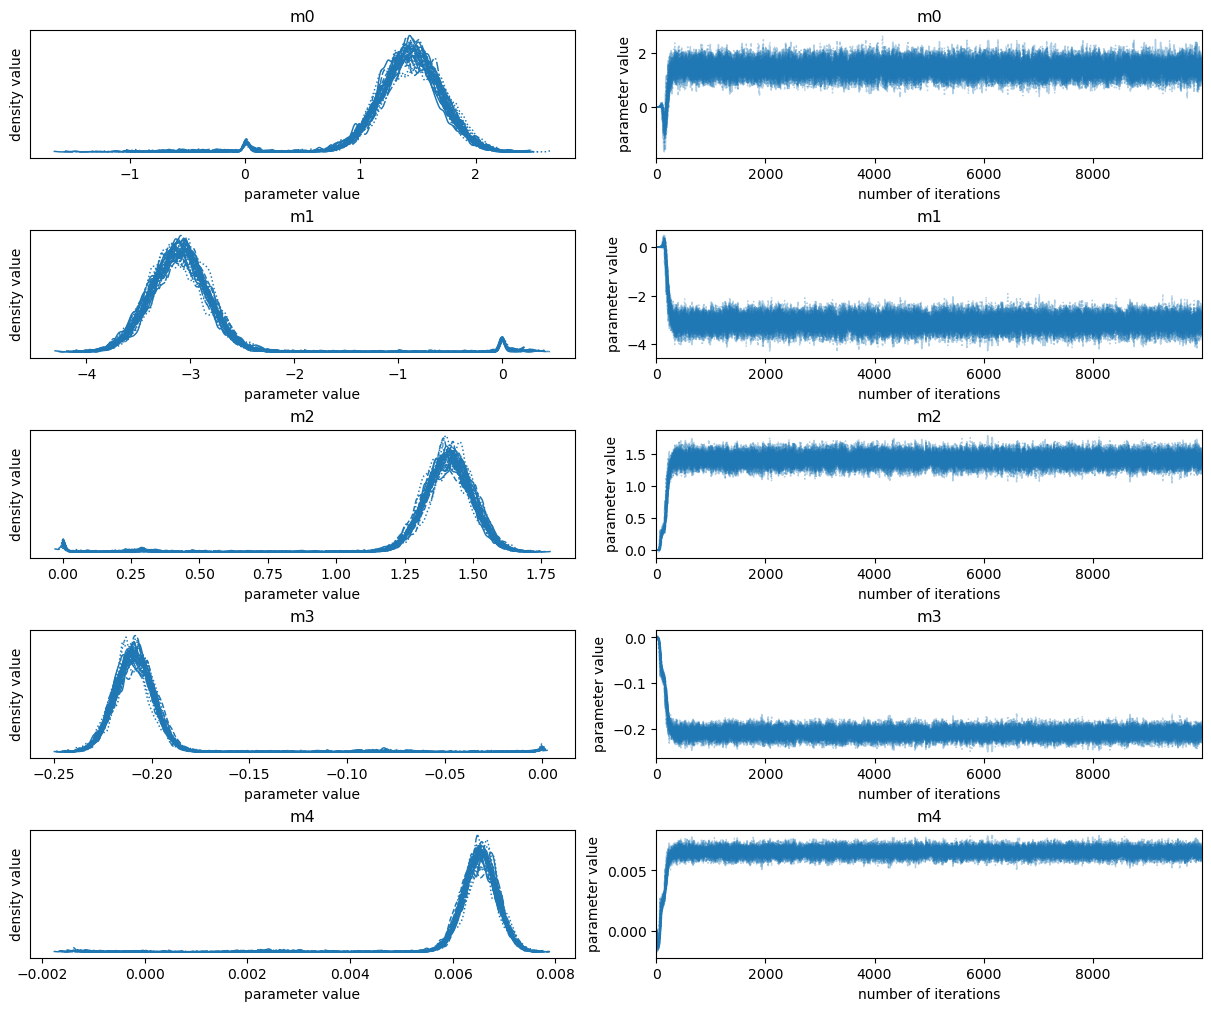

In [32]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [33]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

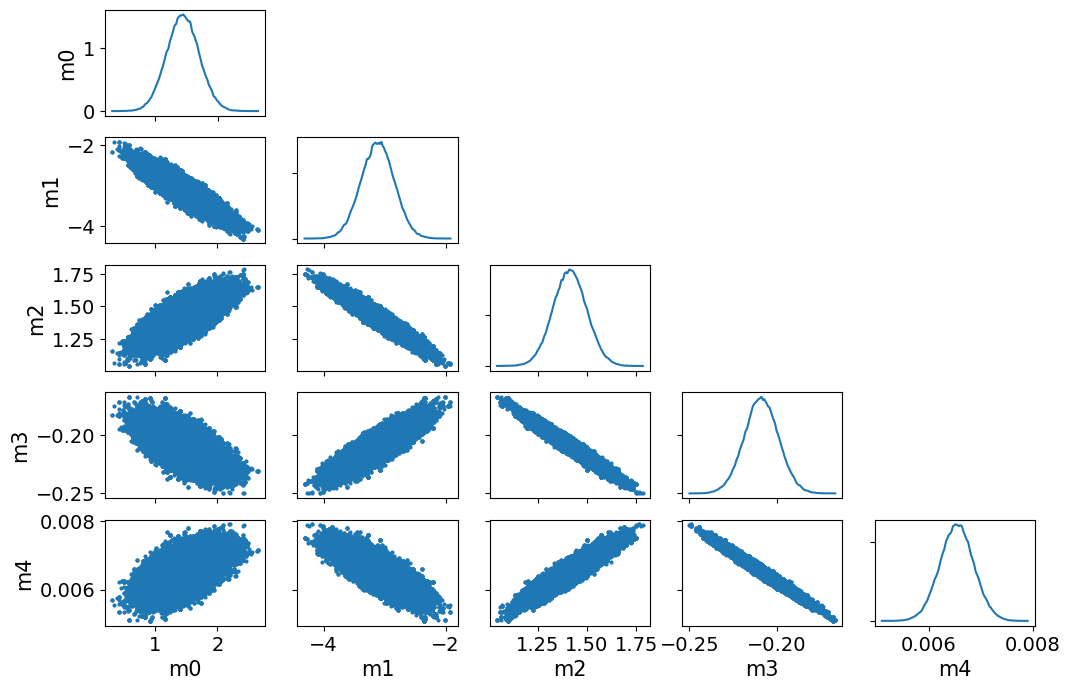

In [34]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

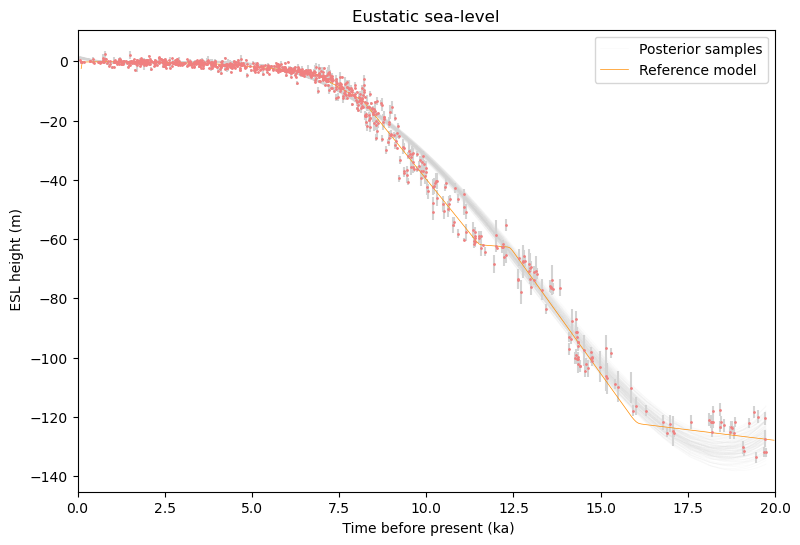

In [35]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [36]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.445 [  1.020,   1.869]
 m1  -3.116 [ -3.563,  -2.675]
 m2   1.414 [  1.276,   1.554]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [37]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.69823930e-02 -6.21502762e-02  1.64145193e-02 -1.56721702e-03
   4.60536953e-05]
 [-6.21502762e-02  7.28053911e-02 -2.17312673e-02  2.24594505e-03
  -6.92734009e-05]
 [ 1.64145193e-02 -2.17312673e-02  7.14529270e-03 -7.91995626e-04
   2.54872601e-05]
 [-1.56721702e-03  2.24594505e-03 -7.91995626e-04  9.27730749e-05
  -3.09139099e-06]
 [ 4.60536953e-05 -6.92734009e-05  2.54872601e-05 -3.09139099e-06
   1.05880597e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2588
    m1  0.2698
    m2  0.0845
    m3  0.0096
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [38]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                                                                                         | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                              | 14/10000 [00:00<01:11, 139.10it/s]

  0%|▌                                                                                                                                                                                                              | 28/10000 [00:00<01:11, 138.88it/s]

  0%|▉                                                                                                                                                                                                              | 43/10000 [00:00<01:11, 139.71it/s]

  1%|█▏                                                                                                                                                                                                             | 57/10000 [00:00<01:11, 139.49it/s]

  1%|█▍                                                                                                                                                                                                             | 72/10000 [00:00<01:11, 139.82it/s]

  1%|█▊                                                                                                                                                                                                             | 87/10000 [00:00<01:10, 139.98it/s]

  1%|██                                                                                                                                                                                                            | 102/10000 [00:00<01:10, 140.12it/s]

  1%|██▍                                                                                                                                                                                                           | 117/10000 [00:00<01:10, 140.08it/s]

  1%|██▋                                                                                                                                                                                                           | 132/10000 [00:00<01:10, 140.17it/s]

  1%|███                                                                                                                                                                                                           | 147/10000 [00:01<01:10, 140.15it/s]

  2%|███▎                                                                                                                                                                                                          | 162/10000 [00:01<01:10, 140.14it/s]

  2%|███▋                                                                                                                                                                                                          | 177/10000 [00:01<01:10, 139.65it/s]

  2%|███▉                                                                                                                                                                                                          | 192/10000 [00:01<01:10, 139.82it/s]

  2%|████▏                                                                                                                                                                                                         | 206/10000 [00:01<01:10, 138.84it/s]

  2%|████▌                                                                                                                                                                                                         | 221/10000 [00:01<01:10, 139.50it/s]

  2%|████▊                                                                                                                                                                                                         | 236/10000 [00:01<01:09, 140.38it/s]

  3%|█████▏                                                                                                                                                                                                        | 251/10000 [00:01<01:08, 142.68it/s]

  3%|█████▌                                                                                                                                                                                                        | 267/10000 [00:01<01:06, 145.91it/s]

  3%|█████▊                                                                                                                                                                                                        | 283/10000 [00:01<01:05, 148.52it/s]

  3%|██████▏                                                                                                                                                                                                       | 299/10000 [00:02<01:04, 150.39it/s]

  3%|██████▍                                                                                                                                                                                                       | 315/10000 [00:02<01:03, 152.04it/s]

  3%|██████▊                                                                                                                                                                                                       | 331/10000 [00:02<01:03, 152.91it/s]

  3%|███████▏                                                                                                                                                                                                      | 347/10000 [00:02<01:02, 154.41it/s]

  4%|███████▍                                                                                                                                                                                                      | 363/10000 [00:02<01:02, 155.03it/s]

  4%|███████▊                                                                                                                                                                                                      | 379/10000 [00:02<01:11, 134.97it/s]

  4%|████████▏                                                                                                                                                                                                     | 395/10000 [00:02<01:08, 139.99it/s]

  4%|████████▍                                                                                                                                                                                                     | 411/10000 [00:02<01:06, 143.98it/s]

  4%|████████▊                                                                                                                                                                                                     | 427/10000 [00:02<01:04, 147.46it/s]

  4%|█████████▏                                                                                                                                                                                                    | 443/10000 [00:03<01:03, 149.64it/s]

  5%|█████████▍                                                                                                                                                                                                    | 459/10000 [00:03<01:03, 150.75it/s]

  5%|█████████▊                                                                                                                                                                                                    | 475/10000 [00:03<01:02, 151.81it/s]

  5%|██████████                                                                                                                                                                                                    | 491/10000 [00:03<01:02, 153.25it/s]

  5%|██████████▍                                                                                                                                                                                                   | 507/10000 [00:03<01:20, 117.64it/s]

  5%|██████████▋                                                                                                                                                                                                   | 521/10000 [00:03<01:17, 121.79it/s]

  5%|███████████                                                                                                                                                                                                   | 537/10000 [00:03<01:12, 130.68it/s]

  6%|███████████▍                                                                                                                                                                                                  | 553/10000 [00:03<01:08, 138.13it/s]

  6%|███████████▋                                                                                                                                                                                                  | 569/10000 [00:04<01:06, 142.63it/s]

  6%|████████████                                                                                                                                                                                                  | 585/10000 [00:04<01:04, 146.88it/s]

  6%|████████████▍                                                                                                                                                                                                 | 601/10000 [00:04<01:02, 149.54it/s]

  6%|████████████▋                                                                                                                                                                                                 | 617/10000 [00:04<01:01, 151.36it/s]

  6%|█████████████                                                                                                                                                                                                 | 633/10000 [00:04<01:01, 152.99it/s]

  6%|█████████████▎                                                                                                                                                                                                | 649/10000 [00:04<01:00, 153.54it/s]

  7%|█████████████▋                                                                                                                                                                                                | 665/10000 [00:04<01:00, 154.05it/s]

  7%|██████████████                                                                                                                                                                                                | 681/10000 [00:04<01:00, 154.34it/s]

  7%|██████████████▎                                                                                                                                                                                               | 697/10000 [00:04<01:00, 154.65it/s]

  7%|██████████████▋                                                                                                                                                                                               | 713/10000 [00:04<01:00, 154.27it/s]

  7%|███████████████                                                                                                                                                                                               | 729/10000 [00:05<00:59, 154.72it/s]

  7%|███████████████▎                                                                                                                                                                                              | 745/10000 [00:05<01:00, 154.15it/s]

  8%|███████████████▋                                                                                                                                                                                              | 761/10000 [00:05<01:00, 153.16it/s]

  8%|████████████████                                                                                                                                                                                              | 777/10000 [00:05<01:00, 151.79it/s]

  8%|████████████████▎                                                                                                                                                                                             | 793/10000 [00:05<00:59, 153.58it/s]

  8%|████████████████▋                                                                                                                                                                                             | 809/10000 [00:05<00:59, 154.89it/s]

  8%|████████████████▉                                                                                                                                                                                             | 825/10000 [00:05<00:58, 155.91it/s]

  8%|█████████████████▎                                                                                                                                                                                            | 842/10000 [00:05<00:58, 157.73it/s]

  9%|█████████████████▋                                                                                                                                                                                            | 858/10000 [00:05<00:57, 158.37it/s]

  9%|██████████████████                                                                                                                                                                                            | 874/10000 [00:05<00:57, 157.39it/s]

  9%|██████████████████▎                                                                                                                                                                                           | 891/10000 [00:06<00:57, 158.00it/s]

  9%|██████████████████▋                                                                                                                                                                                           | 907/10000 [00:06<00:57, 157.43it/s]

  9%|███████████████████                                                                                                                                                                                           | 923/10000 [00:06<00:57, 156.60it/s]

  9%|███████████████████▎                                                                                                                                                                                          | 939/10000 [00:06<00:58, 156.13it/s]

 10%|███████████████████▋                                                                                                                                                                                          | 955/10000 [00:06<00:57, 157.18it/s]

 10%|████████████████████                                                                                                                                                                                          | 971/10000 [00:06<00:57, 157.67it/s]

 10%|████████████████████▎                                                                                                                                                                                         | 988/10000 [00:06<00:56, 158.98it/s]

 10%|████████████████████▌                                                                                                                                                                                        | 1004/10000 [00:06<00:56, 158.84it/s]

 10%|████████████████████▉                                                                                                                                                                                        | 1020/10000 [00:06<00:56, 158.21it/s]

 10%|█████████████████████▏                                                                                                                                                                                       | 1036/10000 [00:06<00:56, 158.27it/s]

 11%|█████████████████████▌                                                                                                                                                                                       | 1052/10000 [00:07<00:57, 156.32it/s]

 11%|█████████████████████▉                                                                                                                                                                                       | 1068/10000 [00:07<00:57, 154.43it/s]

 11%|██████████████████████▏                                                                                                                                                                                      | 1084/10000 [00:07<00:57, 155.84it/s]

 11%|██████████████████████▌                                                                                                                                                                                      | 1100/10000 [00:07<00:57, 156.07it/s]

 11%|██████████████████████▉                                                                                                                                                                                      | 1117/10000 [00:07<00:56, 157.82it/s]

 11%|███████████████████████▏                                                                                                                                                                                     | 1133/10000 [00:07<00:56, 157.06it/s]

 12%|███████████████████████▌                                                                                                                                                                                     | 1150/10000 [00:07<00:56, 157.99it/s]

 12%|███████████████████████▉                                                                                                                                                                                     | 1167/10000 [00:07<00:55, 159.94it/s]

 12%|████████████████████████▎                                                                                                                                                                                    | 1183/10000 [00:07<00:55, 159.68it/s]

 12%|████████████████████████▌                                                                                                                                                                                    | 1199/10000 [00:08<00:55, 157.48it/s]

 12%|████████████████████████▉                                                                                                                                                                                    | 1216/10000 [00:08<00:55, 158.17it/s]

 12%|█████████████████████████▎                                                                                                                                                                                   | 1233/10000 [00:08<00:55, 158.93it/s]

 12%|█████████████████████████▌                                                                                                                                                                                   | 1249/10000 [00:08<00:55, 158.57it/s]

 13%|█████████████████████████▉                                                                                                                                                                                   | 1265/10000 [00:08<00:55, 158.37it/s]

 13%|██████████████████████████▎                                                                                                                                                                                  | 1281/10000 [00:08<00:54, 158.80it/s]

 13%|██████████████████████████▌                                                                                                                                                                                  | 1297/10000 [00:08<00:55, 158.12it/s]

 13%|██████████████████████████▉                                                                                                                                                                                  | 1313/10000 [00:08<00:55, 156.90it/s]

 13%|███████████████████████████▏                                                                                                                                                                                 | 1329/10000 [00:08<00:55, 157.21it/s]

 13%|███████████████████████████▌                                                                                                                                                                                 | 1345/10000 [00:08<00:55, 156.09it/s]

 14%|███████████████████████████▉                                                                                                                                                                                 | 1361/10000 [00:09<00:55, 155.41it/s]

 14%|████████████████████████████▏                                                                                                                                                                                | 1377/10000 [00:09<00:55, 155.66it/s]

 14%|████████████████████████████▌                                                                                                                                                                                | 1393/10000 [00:09<00:55, 156.28it/s]

 14%|████████████████████████████▉                                                                                                                                                                                | 1409/10000 [00:09<00:55, 155.57it/s]

 14%|█████████████████████████████▏                                                                                                                                                                               | 1425/10000 [00:09<00:55, 154.25it/s]

 14%|█████████████████████████████▌                                                                                                                                                                               | 1441/10000 [00:09<00:55, 154.09it/s]

 15%|█████████████████████████████▊                                                                                                                                                                               | 1457/10000 [00:09<00:55, 153.98it/s]

 15%|██████████████████████████████▏                                                                                                                                                                              | 1473/10000 [00:09<00:55, 154.52it/s]

 15%|██████████████████████████████▌                                                                                                                                                                              | 1490/10000 [00:09<00:54, 156.38it/s]

 15%|██████████████████████████████▊                                                                                                                                                                              | 1506/10000 [00:09<00:53, 157.42it/s]

 15%|███████████████████████████████▏                                                                                                                                                                             | 1522/10000 [00:10<00:54, 156.55it/s]

 15%|███████████████████████████████▌                                                                                                                                                                             | 1538/10000 [00:10<00:54, 155.64it/s]

 16%|███████████████████████████████▊                                                                                                                                                                             | 1554/10000 [00:10<00:54, 155.63it/s]

 16%|████████████████████████████████▏                                                                                                                                                                            | 1570/10000 [00:10<00:53, 156.27it/s]

 16%|████████████████████████████████▌                                                                                                                                                                            | 1586/10000 [00:10<00:53, 156.37it/s]

 16%|████████████████████████████████▊                                                                                                                                                                            | 1603/10000 [00:10<00:53, 158.02it/s]

 16%|█████████████████████████████████▏                                                                                                                                                                           | 1619/10000 [00:10<00:53, 157.72it/s]

 16%|█████████████████████████████████▌                                                                                                                                                                           | 1635/10000 [00:10<00:53, 157.82it/s]

 17%|█████████████████████████████████▊                                                                                                                                                                           | 1651/10000 [00:10<00:53, 156.51it/s]

 17%|██████████████████████████████████▏                                                                                                                                                                          | 1667/10000 [00:11<00:53, 156.11it/s]

 17%|██████████████████████████████████▌                                                                                                                                                                          | 1683/10000 [00:11<00:52, 156.98it/s]

 17%|██████████████████████████████████▊                                                                                                                                                                          | 1699/10000 [00:11<00:53, 154.41it/s]

 17%|███████████████████████████████████▏                                                                                                                                                                         | 1715/10000 [00:11<00:53, 155.51it/s]

 17%|███████████████████████████████████▌                                                                                                                                                                         | 1732/10000 [00:11<00:54, 152.47it/s]

 17%|███████████████████████████████████▊                                                                                                                                                                         | 1748/10000 [00:11<00:53, 153.92it/s]

 18%|████████████████████████████████████▏                                                                                                                                                                        | 1764/10000 [00:11<00:53, 154.06it/s]

 18%|████████████████████████████████████▍                                                                                                                                                                        | 1780/10000 [00:11<00:53, 154.57it/s]

 18%|████████████████████████████████████▊                                                                                                                                                                        | 1796/10000 [00:11<00:52, 154.97it/s]

 18%|█████████████████████████████████████▏                                                                                                                                                                       | 1812/10000 [00:11<00:52, 155.13it/s]

 18%|█████████████████████████████████████▍                                                                                                                                                                       | 1828/10000 [00:12<00:52, 156.38it/s]

 18%|█████████████████████████████████████▊                                                                                                                                                                       | 1844/10000 [00:12<00:52, 156.61it/s]

 19%|██████████████████████████████████████▏                                                                                                                                                                      | 1860/10000 [00:12<00:51, 157.19it/s]

 19%|██████████████████████████████████████▍                                                                                                                                                                      | 1876/10000 [00:12<00:52, 155.99it/s]

 19%|██████████████████████████████████████▊                                                                                                                                                                      | 1892/10000 [00:12<00:51, 156.37it/s]

 19%|███████████████████████████████████████                                                                                                                                                                      | 1908/10000 [00:12<00:52, 155.35it/s]

 19%|███████████████████████████████████████▍                                                                                                                                                                     | 1924/10000 [00:12<00:52, 154.47it/s]

 19%|███████████████████████████████████████▊                                                                                                                                                                     | 1940/10000 [00:12<00:52, 153.33it/s]

 20%|████████████████████████████████████████                                                                                                                                                                     | 1956/10000 [00:12<00:52, 154.06it/s]

 20%|████████████████████████████████████████▍                                                                                                                                                                    | 1972/10000 [00:12<00:52, 153.21it/s]

 20%|████████████████████████████████████████▊                                                                                                                                                                    | 1988/10000 [00:13<00:52, 152.39it/s]

 20%|█████████████████████████████████████████                                                                                                                                                                    | 2004/10000 [00:13<00:52, 152.63it/s]

 20%|█████████████████████████████████████████▍                                                                                                                                                                   | 2020/10000 [00:13<00:52, 151.43it/s]

 20%|█████████████████████████████████████████▋                                                                                                                                                                   | 2036/10000 [00:13<00:52, 151.37it/s]

 21%|██████████████████████████████████████████                                                                                                                                                                   | 2052/10000 [00:13<00:52, 152.73it/s]

 21%|██████████████████████████████████████████▍                                                                                                                                                                  | 2068/10000 [00:13<00:51, 153.12it/s]

 21%|██████████████████████████████████████████▋                                                                                                                                                                  | 2084/10000 [00:13<00:51, 152.88it/s]

 21%|███████████████████████████████████████████                                                                                                                                                                  | 2100/10000 [00:13<00:51, 153.61it/s]

 21%|███████████████████████████████████████████▍                                                                                                                                                                 | 2116/10000 [00:13<00:51, 154.15it/s]

 21%|███████████████████████████████████████████▋                                                                                                                                                                 | 2132/10000 [00:14<00:50, 154.47it/s]

 21%|████████████████████████████████████████████                                                                                                                                                                 | 2148/10000 [00:14<00:53, 146.25it/s]

 22%|████████████████████████████████████████████▍                                                                                                                                                                | 2165/10000 [00:14<00:51, 150.73it/s]

 22%|████████████████████████████████████████████▋                                                                                                                                                                | 2181/10000 [00:14<00:51, 153.14it/s]

 22%|█████████████████████████████████████████████                                                                                                                                                                | 2197/10000 [00:14<00:50, 154.13it/s]

 22%|█████████████████████████████████████████████▎                                                                                                                                                               | 2213/10000 [00:14<00:50, 155.20it/s]

 22%|█████████████████████████████████████████████▋                                                                                                                                                               | 2229/10000 [00:14<00:50, 154.91it/s]

 22%|██████████████████████████████████████████████                                                                                                                                                               | 2245/10000 [00:14<00:49, 155.91it/s]

 23%|██████████████████████████████████████████████▎                                                                                                                                                              | 2261/10000 [00:14<00:49, 156.19it/s]

 23%|██████████████████████████████████████████████▋                                                                                                                                                              | 2277/10000 [00:14<00:49, 155.63it/s]

 23%|███████████████████████████████████████████████                                                                                                                                                              | 2293/10000 [00:15<00:49, 154.20it/s]

 23%|███████████████████████████████████████████████▎                                                                                                                                                             | 2309/10000 [00:15<00:50, 152.83it/s]

 23%|███████████████████████████████████████████████▋                                                                                                                                                             | 2325/10000 [00:15<00:50, 153.37it/s]

 23%|███████████████████████████████████████████████▉                                                                                                                                                             | 2341/10000 [00:15<00:49, 154.53it/s]

 24%|████████████████████████████████████████████████▎                                                                                                                                                            | 2357/10000 [00:15<00:49, 154.50it/s]

 24%|████████████████████████████████████████████████▋                                                                                                                                                            | 2373/10000 [00:15<00:49, 153.48it/s]

 24%|████████████████████████████████████████████████▉                                                                                                                                                            | 2389/10000 [00:15<00:49, 152.83it/s]

 24%|█████████████████████████████████████████████████▎                                                                                                                                                           | 2405/10000 [00:15<00:49, 153.57it/s]

 24%|█████████████████████████████████████████████████▋                                                                                                                                                           | 2421/10000 [00:15<00:49, 153.37it/s]

 24%|█████████████████████████████████████████████████▉                                                                                                                                                           | 2437/10000 [00:16<00:49, 153.54it/s]

 25%|██████████████████████████████████████████████████▎                                                                                                                                                          | 2453/10000 [00:16<00:49, 153.64it/s]

 25%|██████████████████████████████████████████████████▌                                                                                                                                                          | 2469/10000 [00:16<00:49, 152.97it/s]

 25%|██████████████████████████████████████████████████▉                                                                                                                                                          | 2485/10000 [00:16<00:48, 154.12it/s]

 25%|███████████████████████████████████████████████████▎                                                                                                                                                         | 2501/10000 [00:16<00:48, 154.13it/s]

 25%|███████████████████████████████████████████████████▌                                                                                                                                                         | 2517/10000 [00:16<00:48, 154.13it/s]

 25%|███████████████████████████████████████████████████▉                                                                                                                                                         | 2533/10000 [00:16<00:48, 154.58it/s]

 26%|████████████████████████████████████████████████████▎                                                                                                                                                        | 2550/10000 [00:16<00:47, 156.53it/s]

 26%|████████████████████████████████████████████████████▌                                                                                                                                                        | 2566/10000 [00:16<00:47, 156.30it/s]

 26%|████████████████████████████████████████████████████▉                                                                                                                                                        | 2582/10000 [00:16<00:47, 155.57it/s]

 26%|█████████████████████████████████████████████████████▎                                                                                                                                                       | 2598/10000 [00:17<00:47, 155.62it/s]

 26%|█████████████████████████████████████████████████████▌                                                                                                                                                       | 2614/10000 [00:17<00:47, 156.38it/s]

 26%|█████████████████████████████████████████████████████▉                                                                                                                                                       | 2630/10000 [00:17<00:47, 155.88it/s]

 26%|██████████████████████████████████████████████████████▎                                                                                                                                                      | 2647/10000 [00:17<00:46, 157.54it/s]

 27%|██████████████████████████████████████████████████████▌                                                                                                                                                      | 2663/10000 [00:17<00:46, 158.02it/s]

 27%|██████████████████████████████████████████████████████▉                                                                                                                                                      | 2679/10000 [00:17<00:46, 157.57it/s]

 27%|███████████████████████████████████████████████████████▏                                                                                                                                                     | 2695/10000 [00:17<00:46, 156.66it/s]

 27%|███████████████████████████████████████████████████████▌                                                                                                                                                     | 2711/10000 [00:17<00:46, 155.71it/s]

 27%|███████████████████████████████████████████████████████▉                                                                                                                                                     | 2727/10000 [00:17<00:46, 155.36it/s]

 27%|████████████████████████████████████████████████████████▏                                                                                                                                                    | 2743/10000 [00:17<00:46, 154.48it/s]

 28%|████████████████████████████████████████████████████████▌                                                                                                                                                    | 2759/10000 [00:18<00:47, 153.16it/s]

 28%|████████████████████████████████████████████████████████▉                                                                                                                                                    | 2775/10000 [00:18<00:46, 154.29it/s]

 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                   | 2791/10000 [00:18<00:47, 153.34it/s]

 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                   | 2807/10000 [00:18<00:46, 153.87it/s]

 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                   | 2823/10000 [00:18<00:46, 153.46it/s]

 28%|██████████████████████████████████████████████████████████▏                                                                                                                                                  | 2839/10000 [00:18<00:46, 154.67it/s]

 29%|██████████████████████████████████████████████████████████▌                                                                                                                                                  | 2855/10000 [00:18<00:45, 155.83it/s]

 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                  | 2871/10000 [00:18<00:46, 154.39it/s]

 29%|███████████████████████████████████████████████████████████▏                                                                                                                                                 | 2887/10000 [00:18<00:46, 153.79it/s]

 29%|███████████████████████████████████████████████████████████▌                                                                                                                                                 | 2903/10000 [00:19<00:46, 153.91it/s]

 29%|███████████████████████████████████████████████████████████▊                                                                                                                                                 | 2919/10000 [00:19<00:45, 155.43it/s]

 29%|████████████████████████████████████████████████████████████▏                                                                                                                                                | 2935/10000 [00:19<00:45, 156.52it/s]

 30%|████████████████████████████████████████████████████████████▍                                                                                                                                                | 2951/10000 [00:19<00:45, 155.60it/s]

 30%|████████████████████████████████████████████████████████████▊                                                                                                                                                | 2967/10000 [00:19<00:44, 156.81it/s]

 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                               | 2983/10000 [00:19<00:44, 156.03it/s]

 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                               | 2999/10000 [00:19<00:45, 154.78it/s]

 30%|█████████████████████████████████████████████████████████████▊                                                                                                                                               | 3015/10000 [00:19<00:44, 156.06it/s]

 30%|██████████████████████████████████████████████████████████████▏                                                                                                                                              | 3031/10000 [00:19<00:44, 156.70it/s]

 30%|██████████████████████████████████████████████████████████████▍                                                                                                                                              | 3047/10000 [00:19<00:44, 156.70it/s]

 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                              | 3063/10000 [00:20<00:44, 155.95it/s]

 31%|███████████████████████████████████████████████████████████████                                                                                                                                              | 3079/10000 [00:20<00:44, 156.90it/s]

 31%|███████████████████████████████████████████████████████████████▍                                                                                                                                             | 3095/10000 [00:20<00:44, 156.66it/s]

 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                             | 3111/10000 [00:20<00:49, 138.29it/s]

 31%|████████████████████████████████████████████████████████████████                                                                                                                                             | 3127/10000 [00:20<00:47, 143.29it/s]

 31%|████████████████████████████████████████████████████████████████▍                                                                                                                                            | 3143/10000 [00:20<00:46, 147.83it/s]

 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                            | 3159/10000 [00:20<00:45, 149.94it/s]

 32%|█████████████████████████████████████████████████████████████████                                                                                                                                            | 3175/10000 [00:20<00:45, 151.24it/s]

 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                           | 3191/10000 [00:20<00:44, 152.38it/s]

 32%|█████████████████████████████████████████████████████████████████▋                                                                                                                                           | 3207/10000 [00:21<00:45, 150.95it/s]

 32%|██████████████████████████████████████████████████████████████████                                                                                                                                           | 3223/10000 [00:21<00:44, 151.82it/s]

 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                          | 3239/10000 [00:21<00:43, 153.79it/s]

 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                          | 3255/10000 [00:21<00:43, 155.05it/s]

 33%|███████████████████████████████████████████████████████████████████                                                                                                                                          | 3271/10000 [00:21<00:43, 153.56it/s]

 33%|███████████████████████████████████████████████████████████████████▍                                                                                                                                         | 3287/10000 [00:21<00:43, 155.15it/s]

 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                         | 3304/10000 [00:21<00:42, 157.77it/s]

 33%|████████████████████████████████████████████████████████████████████                                                                                                                                         | 3320/10000 [00:21<00:42, 157.71it/s]

 33%|████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 3336/10000 [00:21<00:42, 157.60it/s]

 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 3352/10000 [00:21<00:42, 157.22it/s]

 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                        | 3368/10000 [00:22<00:42, 154.61it/s]

 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 3384/10000 [00:22<00:42, 154.86it/s]

 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 3400/10000 [00:22<00:42, 154.92it/s]

 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                       | 3416/10000 [00:22<00:42, 156.01it/s]

 34%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 3432/10000 [00:22<00:42, 154.04it/s]

 34%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 3448/10000 [00:22<00:42, 154.84it/s]

 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                      | 3464/10000 [00:22<00:41, 155.71it/s]

 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 3480/10000 [00:22<00:42, 152.66it/s]

 35%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 3496/10000 [00:22<00:42, 152.74it/s]

 35%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 3512/10000 [00:22<00:42, 153.76it/s]

 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 3528/10000 [00:23<00:42, 153.02it/s]

 35%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 3544/10000 [00:23<00:41, 153.75it/s]

 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 3560/10000 [00:23<00:41, 153.43it/s]

 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 3576/10000 [00:23<00:41, 153.81it/s]

 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 3592/10000 [00:23<00:41, 154.32it/s]

 36%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 3608/10000 [00:23<00:40, 155.92it/s]

 36%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 3625/10000 [00:23<00:40, 157.77it/s]

 36%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 3641/10000 [00:23<00:40, 156.35it/s]

 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 3657/10000 [00:23<00:40, 154.75it/s]

 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 3673/10000 [00:24<00:40, 155.48it/s]

 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 3689/10000 [00:24<00:40, 156.13it/s]

 37%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 3705/10000 [00:24<00:40, 156.32it/s]

 37%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 3721/10000 [00:24<00:40, 156.12it/s]

 37%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 3738/10000 [00:24<00:39, 157.50it/s]

 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 3754/10000 [00:24<00:39, 157.55it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 3771/10000 [00:24<00:39, 158.52it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 3787/10000 [00:24<00:39, 158.84it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 3803/10000 [00:24<00:39, 158.04it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 3819/10000 [00:24<00:39, 158.49it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 3835/10000 [00:25<00:38, 158.23it/s]

 39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 3851/10000 [00:25<00:39, 156.85it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 3867/10000 [00:25<00:39, 155.99it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 3883/10000 [00:25<00:39, 154.84it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 3899/10000 [00:25<00:39, 154.78it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 3915/10000 [00:25<00:39, 155.71it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 3931/10000 [00:25<00:38, 156.53it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 3947/10000 [00:25<00:38, 156.22it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 3964/10000 [00:25<00:38, 158.40it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 3980/10000 [00:25<00:38, 157.11it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 3997/10000 [00:26<00:37, 158.98it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 4014/10000 [00:26<00:37, 159.30it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 4030/10000 [00:26<00:37, 158.57it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 4046/10000 [00:26<00:37, 157.24it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 4063/10000 [00:26<00:37, 159.14it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 4079/10000 [00:26<00:37, 158.87it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 4095/10000 [00:26<00:37, 158.65it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 4111/10000 [00:26<00:37, 158.40it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 4127/10000 [00:26<00:37, 157.27it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 4143/10000 [00:27<00:37, 156.59it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 4159/10000 [00:27<00:37, 155.42it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 4176/10000 [00:27<00:36, 157.63it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 4193/10000 [00:27<00:36, 158.79it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 4209/10000 [00:27<00:36, 157.40it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 4225/10000 [00:27<00:36, 156.28it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 4242/10000 [00:27<00:36, 157.34it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 4258/10000 [00:27<00:36, 157.89it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 4275/10000 [00:27<00:36, 158.98it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 4291/10000 [00:27<00:35, 159.22it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 4307/10000 [00:28<00:35, 158.59it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4323/10000 [00:28<00:35, 158.50it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 4339/10000 [00:28<00:35, 158.03it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 4355/10000 [00:28<00:36, 156.59it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 4371/10000 [00:28<00:36, 156.12it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 4387/10000 [00:28<00:36, 155.52it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 4403/10000 [00:28<00:36, 155.46it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 4419/10000 [00:28<00:35, 155.67it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 4435/10000 [00:28<00:35, 155.60it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 4451/10000 [00:28<00:35, 154.97it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 4467/10000 [00:29<00:35, 155.50it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 4483/10000 [00:29<00:35, 155.93it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 4500/10000 [00:29<00:34, 158.81it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 4517/10000 [00:29<00:34, 159.71it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 4533/10000 [00:29<00:34, 159.73it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 4549/10000 [00:29<00:34, 159.63it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 4565/10000 [00:29<00:34, 158.86it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 4581/10000 [00:29<00:34, 158.11it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 4597/10000 [00:29<00:34, 158.43it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 4614/10000 [00:29<00:33, 159.32it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 4630/10000 [00:30<00:44, 119.83it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 4646/10000 [00:30<00:41, 127.97it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 4662/10000 [00:30<00:39, 135.88it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 4678/10000 [00:30<00:37, 140.77it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 4694/10000 [00:30<00:36, 144.69it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 4710/10000 [00:30<00:36, 146.08it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 4726/10000 [00:30<00:35, 147.61it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 4742/10000 [00:30<00:35, 149.73it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 4758/10000 [00:31<00:34, 151.95it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 4774/10000 [00:31<00:33, 153.93it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 4790/10000 [00:31<00:33, 153.71it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 4806/10000 [00:31<00:43, 118.35it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 4822/10000 [00:31<00:40, 127.27it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 4839/10000 [00:31<00:37, 136.27it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 4855/10000 [00:31<00:36, 141.28it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 4871/10000 [00:31<00:35, 145.70it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 4887/10000 [00:31<00:34, 149.13it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 4904/10000 [00:32<00:33, 152.72it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 4920/10000 [00:32<00:33, 153.60it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 4936/10000 [00:32<00:32, 154.94it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 4952/10000 [00:32<00:32, 155.78it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 4968/10000 [00:32<00:32, 156.04it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 4985/10000 [00:32<00:31, 158.67it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 5001/10000 [00:32<00:31, 158.91it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 5017/10000 [00:32<00:31, 157.02it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 5033/10000 [00:32<00:32, 153.41it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 5049/10000 [00:33<00:32, 153.27it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 5065/10000 [00:33<00:32, 153.90it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 5081/10000 [00:33<00:32, 153.35it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 5097/10000 [00:33<00:31, 154.17it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 5113/10000 [00:33<00:31, 155.63it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 5129/10000 [00:33<00:31, 153.64it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 5145/10000 [00:33<00:31, 153.17it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 5161/10000 [00:33<00:31, 153.48it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 5177/10000 [00:33<00:31, 154.22it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 5193/10000 [00:33<00:31, 154.19it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 5209/10000 [00:34<00:30, 155.51it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 5225/10000 [00:34<00:30, 156.47it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 5241/10000 [00:34<00:30, 157.39it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 5257/10000 [00:34<00:30, 154.59it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5273/10000 [00:34<00:30, 154.73it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 5289/10000 [00:34<00:30, 154.97it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 5305/10000 [00:34<00:30, 154.44it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 5321/10000 [00:34<00:30, 155.56it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 5337/10000 [00:34<00:29, 156.00it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 5353/10000 [00:34<00:29, 156.50it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 5369/10000 [00:35<00:29, 156.60it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 5385/10000 [00:35<00:29, 157.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 5401/10000 [00:35<00:29, 156.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 5417/10000 [00:35<00:29, 156.52it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 5434/10000 [00:35<00:28, 158.55it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 5450/10000 [00:35<00:28, 157.94it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 5466/10000 [00:35<00:28, 156.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 5482/10000 [00:35<00:28, 156.42it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 5498/10000 [00:35<00:28, 156.73it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 5514/10000 [00:35<00:28, 156.30it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 5530/10000 [00:36<00:28, 154.27it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 5546/10000 [00:36<00:28, 155.23it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 5562/10000 [00:36<00:28, 156.61it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 5578/10000 [00:36<00:28, 155.90it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 5594/10000 [00:36<00:28, 155.13it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 5610/10000 [00:36<00:28, 155.36it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 5626/10000 [00:36<00:28, 156.07it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 5642/10000 [00:36<00:28, 155.31it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 5658/10000 [00:36<00:27, 155.36it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 5675/10000 [00:37<00:27, 158.68it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 5691/10000 [00:37<00:27, 158.28it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 5707/10000 [00:37<00:27, 158.51it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 5723/10000 [00:37<00:27, 158.06it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 5739/10000 [00:37<00:27, 157.47it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 5755/10000 [00:37<00:27, 156.81it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 5771/10000 [00:37<00:26, 157.34it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 5788/10000 [00:37<00:26, 158.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 5804/10000 [00:37<00:26, 158.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 5820/10000 [00:37<00:26, 157.59it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 5836/10000 [00:38<00:26, 157.09it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 5852/10000 [00:38<00:26, 156.69it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 5868/10000 [00:38<00:26, 155.46it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 5884/10000 [00:38<00:26, 155.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 5900/10000 [00:38<00:26, 156.34it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 5916/10000 [00:38<00:26, 154.90it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 5932/10000 [00:38<00:26, 155.47it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 5948/10000 [00:38<00:26, 155.68it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 5964/10000 [00:38<00:25, 155.42it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 5980/10000 [00:38<00:25, 155.73it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 5996/10000 [00:39<00:25, 156.23it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 6012/10000 [00:39<00:25, 156.49it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 6028/10000 [00:39<00:25, 156.79it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 6045/10000 [00:39<00:25, 157.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 6061/10000 [00:39<00:24, 157.67it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 6077/10000 [00:39<00:25, 156.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 6094/10000 [00:39<00:24, 158.27it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 6110/10000 [00:39<00:24, 157.98it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 6126/10000 [00:39<00:24, 157.08it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 6142/10000 [00:39<00:24, 156.21it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 6158/10000 [00:40<00:24, 154.97it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 6174/10000 [00:40<00:24, 155.65it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 6190/10000 [00:40<00:24, 155.12it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 6206/10000 [00:40<00:24, 155.54it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 6222/10000 [00:40<00:24, 156.10it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 6238/10000 [00:40<00:24, 153.71it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 6254/10000 [00:40<00:24, 154.96it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 6270/10000 [00:40<00:23, 155.56it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 6286/10000 [00:40<00:23, 155.59it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 6302/10000 [00:41<00:23, 155.76it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 6318/10000 [00:41<00:23, 156.46it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 6334/10000 [00:41<00:23, 157.29it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 6350/10000 [00:41<00:23, 157.96it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 6367/10000 [00:41<00:22, 160.33it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 6384/10000 [00:41<00:22, 160.11it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 6401/10000 [00:41<00:22, 160.58it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 6418/10000 [00:41<00:22, 159.73it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 6434/10000 [00:41<00:22, 158.14it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 6450/10000 [00:41<00:22, 157.94it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 6466/10000 [00:42<00:22, 157.35it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 6482/10000 [00:42<00:22, 156.26it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 6498/10000 [00:42<00:22, 155.79it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 6514/10000 [00:42<00:22, 155.78it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 6530/10000 [00:42<00:22, 155.94it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6546/10000 [00:42<00:22, 156.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6562/10000 [00:42<00:22, 155.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 6578/10000 [00:42<00:21, 156.47it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 6594/10000 [00:42<00:21, 156.61it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 6610/10000 [00:42<00:21, 155.79it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 6626/10000 [00:43<00:21, 154.75it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 6642/10000 [00:43<00:21, 155.27it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 6658/10000 [00:43<00:21, 156.41it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 6674/10000 [00:43<00:21, 156.65it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 6690/10000 [00:43<00:21, 156.12it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 6706/10000 [00:43<00:21, 154.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 6722/10000 [00:43<00:21, 155.50it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 6738/10000 [00:43<00:20, 155.73it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 6755/10000 [00:43<00:20, 158.24it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 6772/10000 [00:44<00:20, 158.96it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 6788/10000 [00:44<00:20, 158.42it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 6804/10000 [00:44<00:20, 158.38it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 6820/10000 [00:44<00:20, 157.55it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 6836/10000 [00:44<00:20, 156.64it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 6852/10000 [00:44<00:20, 156.43it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 6868/10000 [00:44<00:20, 154.36it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 6884/10000 [00:44<00:20, 153.30it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6901/10000 [00:44<00:19, 155.73it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 6917/10000 [00:44<00:19, 155.94it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 6933/10000 [00:45<00:19, 156.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 6949/10000 [00:45<00:19, 156.12it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 6965/10000 [00:45<00:19, 156.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6981/10000 [00:45<00:19, 157.14it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 6997/10000 [00:45<00:19, 156.15it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 7013/10000 [00:45<00:19, 156.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 7029/10000 [00:45<00:19, 155.47it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 7045/10000 [00:45<00:18, 155.99it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 7061/10000 [00:45<00:18, 155.78it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 7077/10000 [00:45<00:18, 155.57it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7093/10000 [00:46<00:18, 155.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7109/10000 [00:46<00:18, 154.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 7125/10000 [00:46<00:18, 155.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7141/10000 [00:46<00:18, 155.02it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 7157/10000 [00:46<00:18, 155.63it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 7173/10000 [00:46<00:18, 155.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 7189/10000 [00:46<00:18, 154.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7205/10000 [00:46<00:17, 155.36it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 7221/10000 [00:46<00:18, 153.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 7237/10000 [00:47<00:17, 154.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 7253/10000 [00:47<00:17, 155.91it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 7269/10000 [00:47<00:17, 156.58it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 7285/10000 [00:47<00:17, 157.24it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 7301/10000 [00:47<00:17, 155.20it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7317/10000 [00:47<00:17, 155.28it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 7333/10000 [00:47<00:17, 155.11it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 7349/10000 [00:47<00:17, 153.98it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7365/10000 [00:47<00:16, 155.52it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 7381/10000 [00:47<00:16, 154.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 7397/10000 [00:48<00:16, 155.94it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7413/10000 [00:48<00:16, 157.10it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 7429/10000 [00:48<00:16, 156.28it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 7446/10000 [00:48<00:16, 157.94it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7463/10000 [00:48<00:15, 158.68it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7479/10000 [00:48<00:16, 156.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 7495/10000 [00:48<00:15, 156.93it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 7511/10000 [00:48<00:15, 156.03it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 7527/10000 [00:48<00:15, 155.23it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 7543/10000 [00:48<00:15, 154.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 7559/10000 [00:49<00:16, 150.21it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7575/10000 [00:49<00:16, 151.01it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 7591/10000 [00:49<00:16, 148.25it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 7606/10000 [00:49<00:16, 146.96it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 7623/10000 [00:49<00:15, 151.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 7639/10000 [00:49<00:15, 153.40it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 7655/10000 [00:49<00:15, 153.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7671/10000 [00:49<00:15, 154.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 7687/10000 [00:49<00:14, 154.37it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7703/10000 [00:50<00:14, 154.71it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 7719/10000 [00:50<00:14, 155.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7735/10000 [00:50<00:14, 154.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 7751/10000 [00:50<00:14, 155.22it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7767/10000 [00:50<00:14, 155.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7783/10000 [00:50<00:14, 155.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7799/10000 [00:50<00:14, 154.46it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 7815/10000 [00:50<00:14, 154.94it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7831/10000 [00:50<00:13, 155.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7847/10000 [00:50<00:13, 156.24it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7863/10000 [00:51<00:13, 155.78it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7879/10000 [00:51<00:13, 154.94it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7895/10000 [00:51<00:13, 156.25it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7911/10000 [00:51<00:13, 157.29it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7928/10000 [00:51<00:13, 158.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7945/10000 [00:51<00:12, 159.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7961/10000 [00:51<00:12, 159.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7977/10000 [00:51<00:12, 159.23it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7993/10000 [00:51<00:12, 158.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8010/10000 [00:51<00:12, 159.41it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 8026/10000 [00:52<00:12, 156.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 8042/10000 [00:52<00:12, 157.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 8058/10000 [00:52<00:12, 156.69it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 8075/10000 [00:52<00:12, 158.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 8091/10000 [00:52<00:12, 157.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8107/10000 [00:52<00:11, 158.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 8123/10000 [00:52<00:11, 157.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8139/10000 [00:52<00:11, 155.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 8155/10000 [00:52<00:11, 157.00it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 8171/10000 [00:53<00:11, 156.01it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 8187/10000 [00:53<00:11, 152.59it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 8203/10000 [00:53<00:11, 152.02it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 8219/10000 [00:53<00:11, 153.11it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 8235/10000 [00:53<00:11, 151.59it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 8251/10000 [00:53<00:11, 150.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 8267/10000 [00:53<00:11, 151.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8283/10000 [00:53<00:11, 154.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 8299/10000 [00:53<00:11, 154.24it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 8315/10000 [00:53<00:10, 154.38it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 8332/10000 [00:54<00:10, 156.36it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8348/10000 [00:54<00:10, 156.10it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8364/10000 [00:54<00:10, 155.51it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8380/10000 [00:54<00:10, 155.93it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8396/10000 [00:54<00:10, 156.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8413/10000 [00:54<00:10, 158.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8429/10000 [00:54<00:09, 157.69it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8446/10000 [00:54<00:09, 158.68it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 8462/10000 [00:54<00:09, 157.99it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 8478/10000 [00:54<00:09, 157.35it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8494/10000 [00:55<00:09, 156.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8510/10000 [00:55<00:09, 156.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8526/10000 [00:55<00:09, 156.32it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8542/10000 [00:55<00:09, 156.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8558/10000 [00:55<00:09, 157.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8574/10000 [00:55<00:09, 157.35it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8591/10000 [00:55<00:08, 158.21it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8607/10000 [00:55<00:08, 157.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8623/10000 [00:55<00:08, 157.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8639/10000 [00:56<00:08, 157.36it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8655/10000 [00:56<00:08, 157.45it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8671/10000 [00:56<00:08, 158.11it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8688/10000 [00:56<00:08, 160.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8705/10000 [00:56<00:08, 159.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8721/10000 [00:56<00:08, 159.42it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8737/10000 [00:56<00:07, 158.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8753/10000 [00:56<00:07, 157.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8770/10000 [00:56<00:07, 159.40it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8786/10000 [00:56<00:07, 158.97it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8802/10000 [00:57<00:07, 158.37it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8818/10000 [00:57<00:07, 156.96it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8834/10000 [00:57<00:07, 157.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8850/10000 [00:57<00:07, 157.12it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8867/10000 [00:57<00:07, 158.25it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8883/10000 [00:57<00:07, 158.11it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8899/10000 [00:57<00:06, 157.72it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8915/10000 [00:57<00:06, 157.64it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8931/10000 [00:57<00:06, 156.51it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8947/10000 [00:57<00:06, 156.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8963/10000 [00:58<00:06, 154.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8979/10000 [00:58<00:06, 156.26it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8995/10000 [00:58<00:06, 154.97it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9011/10000 [00:58<00:06, 154.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9027/10000 [00:58<00:06, 156.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 9044/10000 [00:58<00:06, 158.74it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9060/10000 [00:58<00:05, 158.37it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9076/10000 [00:58<00:05, 157.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9093/10000 [00:58<00:05, 158.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 9109/10000 [00:58<00:05, 158.73it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9125/10000 [00:59<00:05, 157.60it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9141/10000 [00:59<00:05, 157.41it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9157/10000 [00:59<00:05, 156.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9173/10000 [00:59<00:05, 157.36it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9189/10000 [00:59<00:05, 157.60it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9205/10000 [00:59<00:05, 157.66it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9221/10000 [00:59<00:04, 156.27it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9237/10000 [00:59<00:04, 156.33it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9253/10000 [00:59<00:04, 154.96it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9269/10000 [01:00<00:04, 155.61it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9286/10000 [01:00<00:04, 157.47it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9302/10000 [01:00<00:04, 156.98it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9318/10000 [01:00<00:05, 115.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9334/10000 [01:00<00:05, 125.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9350/10000 [01:00<00:04, 133.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9366/10000 [01:00<00:04, 139.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9381/10000 [01:00<00:04, 141.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9397/10000 [01:00<00:04, 145.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9414/10000 [01:01<00:03, 149.80it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9430/10000 [01:01<00:03, 147.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9446/10000 [01:01<00:03, 149.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9462/10000 [01:01<00:03, 151.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9478/10000 [01:01<00:03, 151.37it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9494/10000 [01:01<00:04, 122.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9510/10000 [01:01<00:03, 130.16it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9526/10000 [01:01<00:03, 137.24it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9542/10000 [01:01<00:03, 142.03it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9558/10000 [01:02<00:03, 146.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9574/10000 [01:02<00:02, 147.40it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9590/10000 [01:02<00:02, 149.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9607/10000 [01:02<00:02, 152.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9623/10000 [01:02<00:02, 153.48it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9639/10000 [01:02<00:02, 153.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9655/10000 [01:02<00:02, 153.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9671/10000 [01:02<00:02, 155.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9687/10000 [01:02<00:02, 156.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9703/10000 [01:03<00:01, 156.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9719/10000 [01:03<00:01, 155.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9735/10000 [01:03<00:01, 155.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9751/10000 [01:03<00:01, 155.57it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9767/10000 [01:03<00:01, 127.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9781/10000 [01:03<00:01, 117.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9797/10000 [01:03<00:01, 126.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9813/10000 [01:03<00:01, 133.32it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9829/10000 [01:03<00:01, 138.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9845/10000 [01:04<00:01, 143.02it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9861/10000 [01:04<00:00, 146.06it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9877/10000 [01:04<00:00, 148.24it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9893/10000 [01:04<00:00, 149.24it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9909/10000 [01:04<00:00, 150.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9925/10000 [01:04<00:00, 153.26it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9941/10000 [01:04<00:00, 154.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9957/10000 [01:04<00:00, 155.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9973/10000 [01:04<00:00, 155.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9989/10000 [01:04<00:00, 156.64it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:05<00:00, 153.70it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


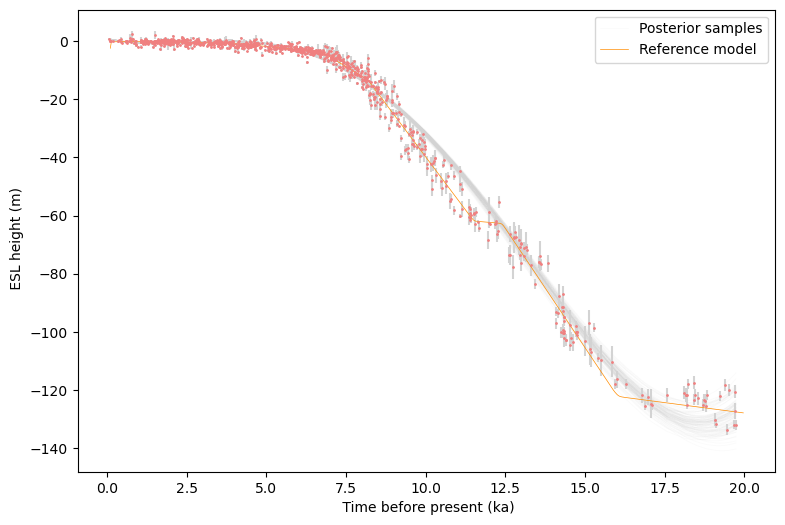

In [39]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

### Trans-dimensional partition modelling

A separate  CoFI example notebook that performs trans-dimensional partition modelling on the same dataset with is also available.

This is called ``Partition_modelling_sealevel_bayesbay.ipynb`` and is available in the directory ``examples/partition_modelling``


---

## Watermark

In [40]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.8
numpy 1.23.5
scipy 1.10.1
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
